In [1]:
# ============================================================
# Cell 1 – Leela‑scope Lightning Simulator v3  (tiers 1 … 9)
# ============================================================
"""
Exactly six stations, harder ‘near/medium/far’, and progressive realism.

Variables & structures are IDENTICAL to the legacy generator:
    stations, station_order, STN           – geography dict / list / alias
    STATIONS                               – extra alias for downstream code
    quantized, station_truth               – raw ADC & truth windows
    events, stroke_records, stroke_samples – ground‑truth meta
    df_wave, df_labels                     – convenience DataFrames
    df_to_quantized(),  df_labels_to_events()
Nothing else downstream needs to change.
"""
# ------------------------------------------------------------
import math, random, numpy as np, pandas as pd
from scipy.signal import butter, filtfilt
# 0)  USER KNOBS ------------------------------------------------------------
SEED          = 424242
duration_min  = 5                 # storm length (min)
scenario      = 'medium'          # 'near' | 'medium' | 'far'
DIFFICULTY    = 5                 # 1 (easy) … 9 (very hard)
FS            = 109_375           # Hz  – keep for pipeline
BITS, VREF    = 14, 1.0
random.seed(SEED); np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# 1)  STATION GEOGRAPHY (always six) ---------------------------------------

stations = {
    'KEF': dict(lat=64.020, lon=-22.567),  # Keflavík
    'VAL': dict(lat=51.930, lon=-10.250),  # Valentia Observatory
    'LER': dict(lat=60.150, lon= -1.130),  # Lerwick
    'HER': dict(lat=50.867, lon=  0.336),  # Herstmonceux
    'GIB': dict(lat=36.150, lon= -5.350),  # Gibraltar
    'AKR': dict(lat=34.588, lon= 32.986),  # Akrotiri
    'CAM': dict(lat=50.217, lon= -5.317),  # Camborne
    'WAT': dict(lat=52.127, lon=  0.956),  # Wattisham
    'CAB': dict(lat=51.970, lon=  4.930),  # Cabauw
    'PAY': dict(lat=46.820, lon=  6.950),  # Payerne
    'TAR': dict(lat=58.263, lon= 26.464),  # Tõravere
}

station_order = list(stations.keys())    # fixed order
STN      = station_order
STATIONS = station_order                 # alias used in other notebooks
N_STN    = len(STN)

# 2)  Helpers ---------------------------------------------------------------
def hav(lat1, lon1, lat2, lon2):
    R=6371.0
    φ1,φ2 = map(math.radians, (lat1,lat2))
    dφ    = math.radians(lat2-lat1)
    dλ    = math.radians(lon2-lon1)
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

# 3)  Timeline --------------------------------------------------------------
pre_sec   = rng.uniform(5,30)
storm_sec = duration_min*60
total_sec = pre_sec + storm_sec
N         = int(total_sec*FS)

quantized      = {nm: np.zeros(N, np.int16)   for nm in STN}
station_truth  = {nm: np.zeros(N//1024, bool) for nm in STN}
events, stroke_records, burst_book = [], [], []

# 4)  Tier flags ------------------------------------------------------------
flags = dict(
    ic_mix          = DIFFICULTY>=2,
    multipath       = DIFFICULTY>=3,
    coloured_noise  = DIFFICULTY>=4,
    rfi             = DIFFICULTY>=5,
    sprite_ring     = DIFFICULTY>=5,
    false_transient = DIFFICULTY>=5,
    clipping        = DIFFICULTY>=5,
    multi_cell      = DIFFICULTY>=6,
    skywave         = DIFFICULTY>=7,
    bg_sferics      = DIFFICULTY>=7,
    clock_skew      = DIFFICULTY>=8,
    gain_drift      = DIFFICULTY>=8,
    dropouts        = DIFFICULTY>=8,
    low_snr         = DIFFICULTY>=9,
    burst_div       = DIFFICULTY>=9,
)

# 5)  Storm‑cell geometry ----------------------------------------------------
lat0 = np.mean([s['lat'] for s in stations.values()])
lon0 = np.mean([s['lon'] for s in stations.values()])
R0   = dict(near=100, medium=400, far=900)[scenario]   # tougher radii

n_cells = 1 if not flags['multi_cell'] else rng.integers(2,5)
cells=[]
for _ in range(n_cells):
    θ   = rng.uniform(0,2*math.pi)
    rad = R0*rng.uniform(0.3,1.0)
    cells.append(dict(
        lat   = lat0 + (rad/111)*math.cos(θ),
        lon   = lon0 + (rad/111)*math.sin(θ)/math.cos(math.radians(lat0)),
        drift = rng.uniform(-0.20,0.20,2)          # deg·h‑1
    ))

# 6)  Flash & stroke generation ---------------------------------------------
wave_len = int(0.04*FS)
tv       = np.arange(wave_len)/FS
rfi_freqs= [14400,20100,30300]

eid, t = 0, pre_sec
while True:
    cell = cells[rng.integers(len(cells))]
    c_age= t-pre_sec
    c_lat= cell['lat'] + cell['drift'][0]*c_age/3600
    c_lon= cell['lon'] + cell['drift'][1]*c_age/3600
    t   += rng.lognormal(3,1)* (0.4 if flags['multi_cell'] else 1)
    if t>=total_sec: break
    eid += 1
    # flash location
    d = rng.uniform(0,R0)
    φ = rng.uniform(0,2*math.pi)
    f_lat = c_lat + (d/111)*math.cos(φ)
    f_lon = c_lon + (d/111)*math.sin(φ)/math.cos(math.radians(lat0))
    f_type= 'IC' if (flags['ic_mix'] and rng.random()<0.3) else 'CG'
    n_str = rng.integers(1, 4 if f_type=='IC' else 7)
    amp0  = 0.35 if f_type=='IC' else 1.0
    s_times = sorted(t + rng.uniform(0,0.06,size=n_str))
    events.append(dict(id=eid,flash_type=f_type,lat=f_lat,lon=f_lon,
                       stroke_times=s_times))
    # build bursts
    for si, t0 in enumerate(s_times):
        for nm in STN:
            dist = hav(f_lat,f_lon, stations[nm]['lat'],stations[nm]['lon'])
            idx  = int((t0 + dist/300_000 + rng.uniform(-50,50)/1e6)*FS)
            if idx>=N: continue
            # waveform
            if flags['burst_div'] and rng.random()<0.15:
                tau=.0008; burst = (tv/tau)*np.exp(1-tv/tau)
            else:
                f0=rng.uniform(2500,9500); tau=rng.uniform(0.0003,0.0025)
                burst = np.sin(2*math.pi*f0*tv)*np.exp(-tv/tau)
            amp = amp0*rng.uniform(2,5)/(1+dist/40)
            if flags['low_snr']: amp*=0.4
            burst *= amp
            # multipath
            if flags['multipath'] and dist>60:
                dly=int(rng.uniform(0.001,0.0035)*FS)
                if dly<wave_len: burst[dly:]+=0.35*burst[:-dly]
            # sprite ringers
            if flags['sprite_ring'] and rng.random()<0.04:
                dly=int(rng.uniform(0.008,0.018)*FS)
                if dly<wave_len: burst[dly:]+=0.25*burst[:-dly]
            # sky‑wave attenuation
            if flags['skywave'] and dist>600:
                f=np.fft.rfftfreq(wave_len,1/FS)
                H=np.exp(-0.00025*dist*((f/6e3)**2))
                burst=np.fft.irfft(np.fft.rfft(burst)*H,n=wave_len)
            burst_book.append((nm,idx,burst.astype(np.float32)))
            station_truth[nm][idx//1024]=True
            stroke_records.append(dict(event_id=eid,stroke_i=si,station=nm,
                                       flash_type=f_type,lat=f_lat,lon=f_lon,
                                       true_time_s=t0,sample_idx=idx,
                                       window_idx=idx//1024))
            #if nm==STN[0]: stroke_samples.append(idx)

# 7)  Noise profiles ---------------------------------------------------------
noise_cfg={}
for nm in STN:
    base_white=rng.uniform(0.010,0.017)
    tones=[]
    if flags['rfi'] and rng.random()<0.6:
        tones=[(rng.choice(rfi_freqs), rng.uniform(0.001,0.004))]
    noise_cfg[nm]=dict(
        w = base_white if not flags['coloured_noise'] else base_white*rng.uniform(1,1.8),
        h = 0.01 if not flags['coloured_noise'] else rng.uniform(0.006,0.020),
        tones = tones,
        gain_drift = rng.uniform(-0.05,0.05) if flags['gain_drift'] else 0.0,
        skew = rng.uniform(-20e-6,20e-6) if flags['clock_skew'] else 0.0
    )

# 8)  ADC synthesis loop -----------------------------------------------------
b,a  = butter(4, 45000/(FS/2),'low')
chunk= int(20*FS)
tv40 = np.arange(wave_len)/FS   # for false‑transient reuse

for nm in STN:
    bur = [b for b in burst_book if b[0]==nm]
    cfg = noise_cfg[nm]
    drop = np.ones(N,bool)
    if flags['dropouts'] and rng.random()<0.1:
        for _ in range(rng.integers(1,3)):
            s=rng.integers(int(pre_sec*FS),N-int(0.4*FS))
            drop[s:s+int(0.4*FS)]=False
    for s0 in range(0,N,chunk):
        e0=min(N,s0+chunk); L=e0-s0
        t=np.arange(s0,e0)/FS
        seg = cfg['w']*rng.standard_normal(L) + cfg['h']*np.sin(2*math.pi*50*t)
        for f,amp in cfg['tones']:
            seg += amp*np.sin(2*math.pi*f*t + rng.uniform(0,2*math.pi))
        # gain drift
        seg *= 1 + cfg['gain_drift']*(t-pre_sec)/(storm_sec+1e-9)
        # add bursts
        for (_,i0,br) in bur:
            if s0<=i0<e0:
                off=i0-s0; l=min(len(br),L-off)
                seg[off:off+l]+=br[:l]
        # false transient
        if flags['false_transient'] and rng.random()<0.002:
            idx=rng.integers(0,L-wave_len)
            seg[idx:idx+wave_len]+=0.7*np.sin(2*math.pi*5800*tv40)*np.exp(-tv40/0.0009)
        # filtering & clipping
        seg = filtfilt(b,a,seg)
        if flags['clipping']: seg=np.clip(seg,-0.9*VREF,0.9*VREF)
        full=2**(BITS-1)-1
        adc = np.clip(np.round(seg/VREF*full), -full, full).astype(np.int16)
        quantized[nm][s0:e0][drop[s0:e0]] = adc[drop[s0:e0]]

# 9)  DataFrames -------------------------------------------------------------
df_wave = pd.DataFrame({'time_s':np.arange(N)/FS})
for nm in STN: df_wave[nm]=quantized[nm]
df_labels = pd.DataFrame(stroke_records)

def df_to_quantized(df):      return {nm:df[nm].values.astype(np.int16) for nm in STN}
def df_labels_to_events(df):
    out=[];      grp=df.groupby('event_id')
    for eid,g in grp:
        out.append(dict(id=eid,flash_type=g.flash_type.iloc[0],
                        lat=g.lat.iloc[0],lon=g.lon.iloc[0],
                        stroke_times=sorted(g.true_time_s.unique())))
    return out

# 10)  Summary --------------------------------------------------------------
print(f"Tier‑{DIFFICULTY} | scenario={scenario} | cells={n_cells}")
print(f"Flashes {len(events):3d} | strokes {len(df_labels)//N_STN:3d} "
      f"| samples {N:,}")


Tier‑5 | scenario=medium | cells=1
Flashes  11 | strokes  45 | samples 34,657,100


In [2]:
df_labels

,event_id,stroke_i,station,flash_type,lat,lon,true_time_s,sample_idx,window_idx
0,1,0,KEF,IC,52.475825,3.946231,65.392834,7153070,6985
1,1,0,VAL,IC,52.475825,3.946231,65.392834,7152689,6985
2,1,0,LER,IC,52.475825,3.946231,65.392834,7152669,6985
3,1,0,HER,IC,52.475825,3.946231,65.392834,7152452,6984
4,1,0,GIB,IC,52.475825,3.946231,65.392834,7153058,6985
...,...,...,...,...,...,...,...,...,...
490,11,4,CAM,CG,52.493444,5.870292,308.159511,33705243,32915
491,11,4,WAT,CG,52.493444,5.870292,308.159511,33705067,32915
492,11,4,CAB,CG,52.493444,5.870292,308.159511,33704982,32915
493,11,4,PAY,CG,52.493444,5.870292,308.159511,33705181,32915


In [3]:
##############################################################################
#  Lightning‑storm generator 2.4  –  calibrated amplitude + sensible path loss
#  --------------------------------------------------------------------------
#  Produces:  quantized  stroke_records  events  burst_book
##############################################################################

import math, random, numpy as np, pandas as pd
from scipy.signal import butter, filtfilt

# ───── user knobs ──────────────────────────────────────────────────────────
SEED          = 424242
duration_min  = 5                     # storm duration
scenario      = 'medium'              # near | medium | far
DIFFICULTY    = 1                     # 1 (easy) … 9 (very hard)
SNR_dB        =  -2.0                  # –18 … +18 dB recommended
FS            = 109_375               # Hz
BITS, VREF    = 14, 1.0

if not -18 <= SNR_dB <= 24:
    print(f"[warning] SNR_dB={SNR_dB} is outside the calibrated range.")

random.seed(SEED); np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# ───── geometry & helpers ─────────────────────────────────────────────────
stations = {  # 11 European LF stations
    'KEF': dict(lat=64.020, lon=-22.567),  'VAL': dict(lat=51.930, lon=-10.250),
    'LER': dict(lat=60.150, lon= -1.130),  'HER': dict(lat=50.867, lon=  0.336),
    'GIB': dict(lat=36.150, lon= -5.350),  'AKR': dict(lat=34.588, lon= 32.986),
    'CAM': dict(lat=50.217, lon= -5.317),  'WAT': dict(lat=52.127, lon=  0.956),
    'CAB': dict(lat=51.970, lon=  4.930),  'PAY': dict(lat=46.820, lon=  6.950),
    'TAR': dict(lat=58.263, lon= 26.464),
}
STN = list(stations)

def hav(lat1, lon1, lat2, lon2):
    R = 6371.0
    φ1, φ2 = map(math.radians, (lat1, lat2))
    dφ, dλ = math.radians(lat2-lat1), math.radians(lon2-lon1)
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

def path_loss(dist_km: float) -> float:
    """
    Empirical vertical‑E attenuation:  ~d⁻¹·¹  + moderate ground loss.
    Boost 3 dB for first ionospheric hop beyond ~600 km.
    """
    loss = (100/(dist_km + 100))**0.85 * math.exp(-0.0001*dist_km)
    if dist_km > 600:
        loss *= math.sqrt(2)          # +3 dB
    return loss

# ───── difficulty flags (unchanged) ───────────────────────────────────────
flags = dict(
    ic_mix          = DIFFICULTY>=2,
    multipath       = DIFFICULTY>=3,
    coloured_noise  = DIFFICULTY>=4,
    rfi_tones       = DIFFICULTY>=5,
    impulsive_rfi   = DIFFICULTY>=6,
    sprite_ring     = DIFFICULTY>=5,
    false_transient = DIFFICULTY>=6,
    clipping        = DIFFICULTY>=5,
    multi_cell      = DIFFICULTY>=6,
    skywave         = DIFFICULTY>=7,
    sferic_bed      = DIFFICULTY>=7,
    clock_skew      = DIFFICULTY>=8,
    gain_drift      = DIFFICULTY>=8,
    dropouts        = DIFFICULTY>=8,
    low_snr         = DIFFICULTY>=9,
    burst_div       = DIFFICULTY>=9,
)

# ───── timeline containers ────────────────────────────────────────────────
pre_sec   = rng.uniform(5, 30)
storm_sec = duration_min * 60
N         = int((pre_sec + storm_sec) * FS)

quantized       = {nm: np.zeros(N, np.int16) for nm in STN}
events, stroke_records, burst_book = [], [], []

# ───── storm cells ────────────────────────────────────────────────────────
lat_v = np.fromiter((s['lat'] for s in stations.values()), float)
lon_v = np.fromiter((s['lon'] for s in stations.values()), float)
lat_box = (lat_v.min()-0.9, lat_v.max()+0.9)
lon_box = (lon_v.min()-1.5, lon_v.max()+1.5)

def new_cell():
    return dict(
        lat   = rng.uniform(*lat_box),
        lon   = rng.uniform(*lon_box),
        drift = rng.uniform(-0.30, 0.30, 2)
    )

cells = [new_cell() for _ in range(1 if not flags['multi_cell']
                                   else rng.integers(2, 5))]
R0_km = dict(near=120, medium=400, far=1000)[scenario]

# ───── waveform library ───────────────────────────────────────────────────
wave_len = int(0.04 * FS)
tv40     = np.arange(wave_len) / FS
SNR_lin  = 10**(SNR_dB/20)               # user knob

V_REF_CG = 0.15        # volts peak at 100 km for CG
V_REF_IC = 0.06        # typical IC is ~8 dB weaker

def make_burst(dist_km: float, cg: bool = True) -> np.ndarray:
    """Return 40 ms LF burst with calibrated amplitude and artefacts."""
    # 1) base analytical sferic
    if flags['burst_div'] and rng.random() < 0.15:
        τ = 0.0008
        burst = (tv40/τ) * np.exp(1 - tv40/τ)
    else:
        f0 = rng.uniform(3e3, 15e3)
        τ  = rng.uniform(0.00025, 0.001 if cg else 0.0005)
        burst = np.sin(2*math.pi*f0*tv40) * np.exp(-tv40/τ)

    # 2) physically anchored amplitude
    Vpeak = (V_REF_CG if cg else V_REF_IC)
    Vpeak *= path_loss(dist_km) / path_loss(100.0)
    Vpeak *= 10**(rng.uniform(-3, 3)/20) * SNR_lin
    if flags['low_snr']:
        Vpeak *= 0.5
    burst *= Vpeak / (np.abs(burst).max() + 1e-12)

    # 3) artefacts
    if flags['multipath'] and dist_km > 80 and rng.random() < 0.6:
        dly = int(rng.uniform(0.001, 0.004) * FS)
        if dly < wave_len:
            burst[dly:] += 0.35 * burst[:-dly]
    if flags['sprite_ring'] and rng.random() < 0.05:
        dly = int(rng.uniform(0.008, 0.018) * FS)
        if dly < wave_len:
            burst[dly:] += 0.25 * burst[:-dly]
    if flags['skywave'] and dist_km > 600:
        f = np.fft.rfftfreq(wave_len, 1/FS)
        H = np.exp(-0.00030*dist_km * (f/7e3)**2)
        burst = np.fft.irfft(np.fft.rfft(burst) * H, n=wave_len)

    return burst.astype(np.float32)

# ───── flash & stroke scheduler ───────────────────────────────────────────
λ_flash = dict(near=8, medium=4, far=2)[scenario] * (1 + 0.4*DIFFICULTY)
flash_ts, eid = pre_sec, 0

while flash_ts < pre_sec + storm_sec:
    flash_ts += rng.exponential(60/λ_flash)     # λ = flashes / min
    if flash_ts >= pre_sec + storm_sec:
        break
    eid += 1

    cell  = rng.choice(cells)
    age_h = (flash_ts - pre_sec) / 3600
    f_lat = cell['lat'] + cell['drift'][0]*age_h
    f_lon = cell['lon'] + cell['drift'][1]*age_h
    r_km  = rng.uniform(0, R0_km); θ = rng.uniform(0, 2*math.pi)
    f_lat += (r_km/111)*math.cos(θ)
    f_lon += (r_km/111)*math.sin(θ) / math.cos(math.radians(f_lat))

    f_type = 'IC' if (flags['ic_mix'] and rng.random() < 0.35) else 'CG'
    n_str  = rng.integers(1, 4 if f_type == 'IC' else 6)
    gaps   = rng.exponential(0.008, n_str)
    s_times = [flash_ts + float(gaps[:i+1].sum()) for i in range(n_str)]

    events.append(dict(id=eid, flash_type=f_type, lat=f_lat, lon=f_lon,
                       stroke_times=s_times))

    for si, t0 in enumerate(s_times):
        for nm in STN:
            dist = hav(f_lat, f_lon, stations[nm]['lat'], stations[nm]['lon'])
            idx  = int((t0 + dist/300_000 + rng.normal(0, 40e-6)) * FS)
            if idx >= N - wave_len:
                continue
            burst_book.append((nm, idx, make_burst(dist, cg=(f_type == 'CG'))))
            stroke_records.append(dict(event_id=eid, stroke_i=si, station=nm,
                                       flash_type=f_type, lat=f_lat, lon=f_lon,
                                       true_time_s=t0, sample_idx=idx,
                                       window_idx=idx//1024))

# ───── noise & ADC synthesis ──────────────────────────────────────────────
rfi_tones = [14_400, 20_100, 30_300]
b, a      = butter(4, 45_000/(FS/2), 'low')
chunk     = int(20*FS)
tv_wave   = tv40

for nm in STN:
    bursts = [(i0, br) for st, i0, br in burst_book if st == nm]
    cfg = dict(
        white=rng.uniform(0.010, 0.018),
        hum=rng.uniform(0.006, 0.020) if flags['coloured_noise'] else 0.01,
        tones=[] if not flags['rfi_tones'] else
              [(rng.choice(rfi_tones), rng.uniform(0.001, 0.004))],
        gain_drift=rng.uniform(-0.05, 0.05) if flags['gain_drift'] else 0.0,
        skew=rng.uniform(-25e-6, 25e-6)    if flags['clock_skew'] else 0.0
    )

    drop = np.ones(N, bool)
    if flags['dropouts'] and rng.random() < 0.1:
        for _ in range(rng.integers(1, 3)):
            s = rng.integers(int(pre_sec*FS), N - int(0.4*FS))
            drop[s:s+int(0.4*FS)] = False

    for s0 in range(0, N, chunk):
        e0 = min(N, s0 + chunk)
        L  = e0 - s0
        t  = np.arange(s0, e0) / FS * (1 + cfg['skew'])

        seg = (cfg['white'] * rng.standard_normal(L) +
               cfg['hum']   * np.sin(2*math.pi*50*t))
        for f, amp in cfg['tones']:
            seg += amp * np.sin(2*math.pi*f*t + rng.uniform(0, 2*math.pi))
        if flags['sferic_bed']:
            seg += 0.0008 * rng.standard_normal(L)

        seg *= 1 + cfg['gain_drift'] * (t - pre_sec) / (storm_sec + 1e-6)

        for i0, br in bursts:
            if s0 <= i0 < e0:
                off = i0 - s0
                seg[off:off+wave_len] += br[:min(wave_len, L-off)]

        if flags['impulsive_rfi'] and rng.random() < 0.002:
            p = rng.integers(0, L-200)
            seg[p:p+200] += rng.uniform(-0.9, 0.9) * np.hanning(200)
        if flags['false_transient'] and rng.random() < 0.003:
            p = rng.integers(0, L-wave_len)
            seg[p:p+wave_len] += (0.6*np.sin(2*math.pi*5800*tv_wave) *
                                  np.exp(-tv_wave/0.0009))

        seg = filtfilt(b, a, seg)
        if flags['clipping']:
            seg = np.clip(seg, -0.9*VREF, 0.9*VREF)
        full = 2**(BITS-1) - 1
        adc  = np.clip(np.round(seg/VREF*full), -full, full).astype(np.int16)
        quantized[nm][s0:e0][drop[s0:e0]] = adc[drop[s0:e0]]

# ───── optional DataFrames -------------------------------------------------
df_wave   = pd.DataFrame({'time_s': np.arange(N)/FS})
for nm in STN:
    df_wave[nm] = quantized[nm]
df_labels = pd.DataFrame(stroke_records)

print(f"Tier‑{DIFFICULTY}  SNR={SNR_dB:+.1f} dB  scenario={scenario}  cells={len(cells)}")
print(f"Flashes {len(events):3d} | strokes {len(df_labels)//len(STN):3d} "
      f"| samples {N:,}")


Tier‑1  SNR=-2.0 dB  scenario=medium  cells=1
Flashes  18 | strokes  49 | samples 34,657,100


► Simulator difficulty tier : 1
► Sampling rate             : 109,375 Hz (Δt=9.14 µs)
► Duration                  : 316.86 s  (5.28 min)
► Total ADC samples         : 34,657,100

STN  min  max  μ  σ  non‑zero %
KEF  -692  649  -0.0  123.2  99.68%
VAL  -631  624  0.0  120.5  99.67%
LER  -638  707  -0.0  126.1  99.69%
HER  -694  718  0.0  134.0  99.70%
GIB  -1587  1650  -0.0  141.7  99.72%
AKR  -494  494  0.0  98.2  99.61%
CAM  -486  480  0.0  96.8  99.60%
WAT  -474  466  0.0  96.9  99.60%
CAB  -494  534  0.0  99.3  99.61%
PAY  -581  593  -0.0  112.2  99.65%
TAR  -627  585  -0.0  118.3  99.67%

Flashes  : 18
Strokes  : 49



,time_s,lat,lon
0,20.205889,37.372067,-7.469461
1,20.223197,37.372067,-7.469461
2,20.232793,37.372067,-7.469461
3,20.234875,37.372067,-7.469461
4,20.261659,37.372067,-7.469461


STN  simple detection rate
KEF  0.0%
VAL  2.0%
LER  0.0%
HER  0.0%
GIB  0.0%
AKR  0.0%
CAM  0.0%
WAT  0.0%
CAB  0.0%
PAY  0.0%
TAR  0.0%


Windows: quiet=33807, lightning=37


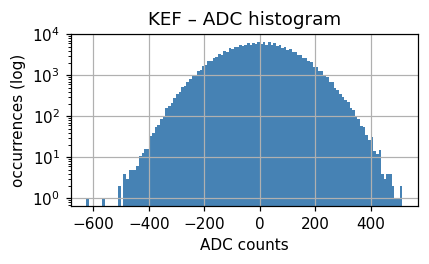

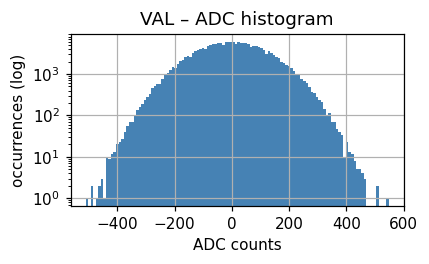

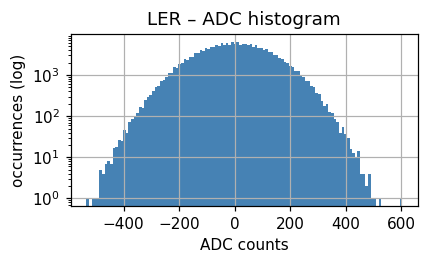

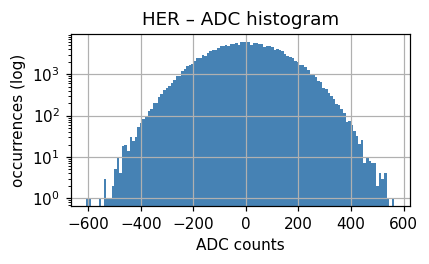

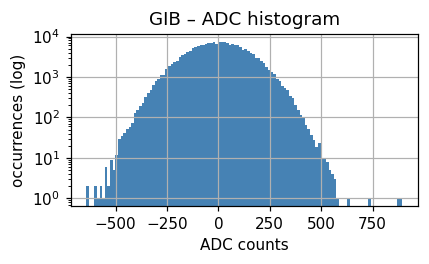

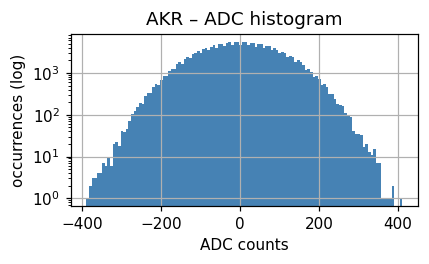

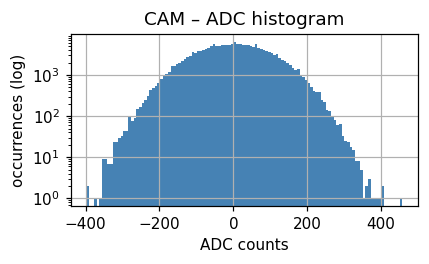

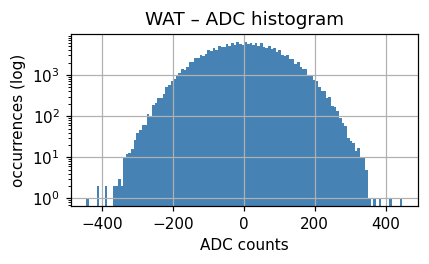

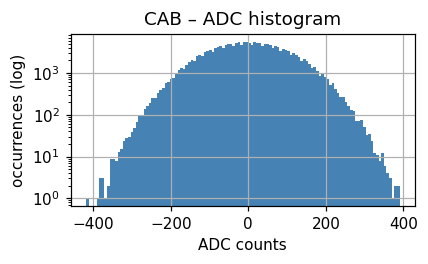

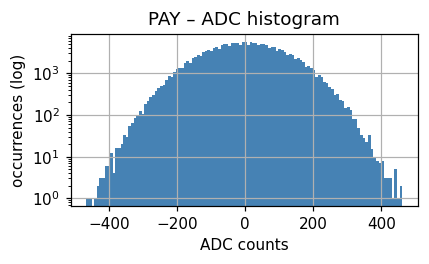

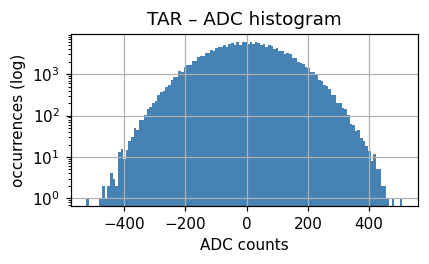

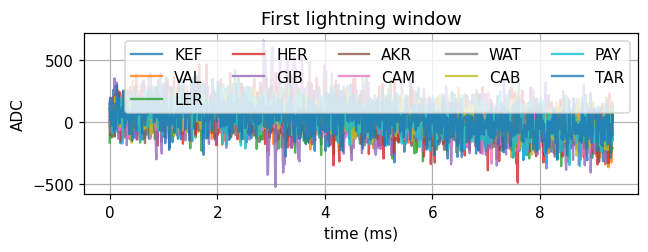

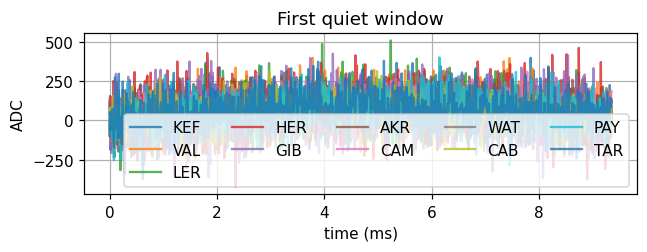

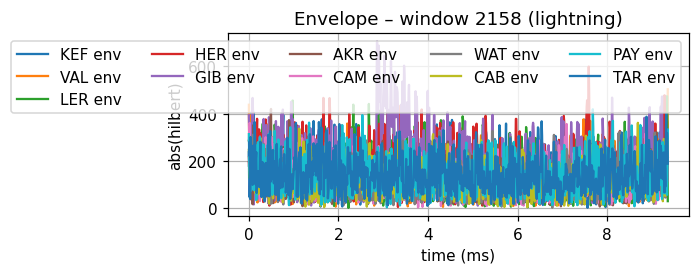

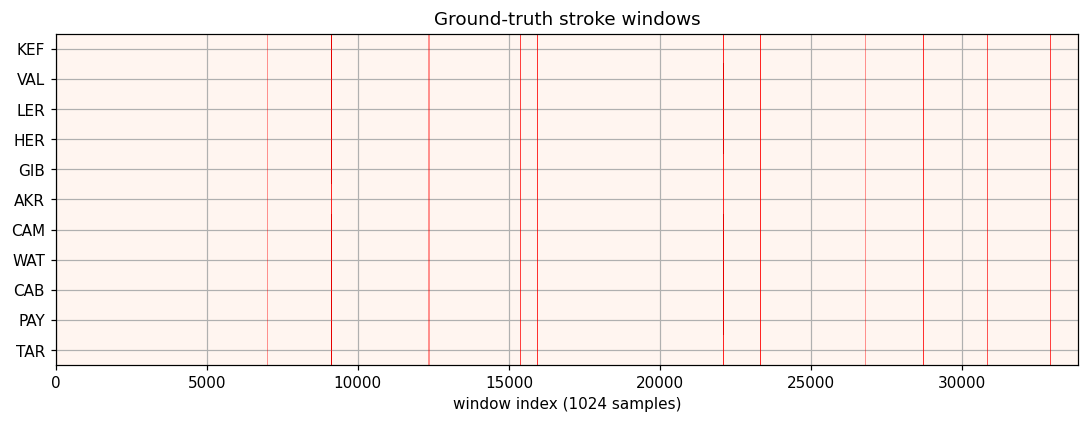

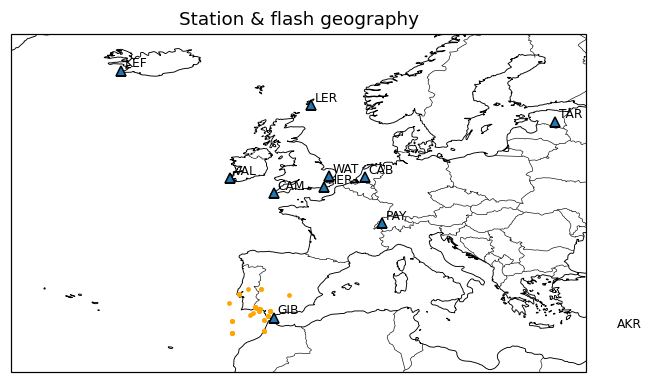

In [4]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import hilbert
plt.rcParams.update({'axes.grid': True, 'figure.dpi': 110})

# -----------------------------------------------------------------
# 0)  Helper: concise console table printer
# -----------------------------------------------------------------
def _tbl(rows, hdr=None, col_sep="  "):
    if hdr: print(col_sep.join(hdr))
    for r in rows:
        print(col_sep.join(str(c) for c in r))
    print()

# -----------------------------------------------------------------
# 1)  Global metadata
# -----------------------------------------------------------------
N   = quantized[station_order[0]].size
dur = N / FS
print(f"► Simulator difficulty tier : {DIFFICULTY}")
print(f"► Sampling rate             : {FS:,.0f} Hz "
      f"(Δt={1e6/FS:.2f} µs)")
print(f"► Duration                  : {dur:.2f} s  ({dur/60:.2f} min)")
print(f"► Total ADC samples         : {N:,}\n")

# -----------------------------------------------------------------
# 2)  Per‑station ADC statistics
# -----------------------------------------------------------------
rows=[]
for nm in station_order:
    q = quantized[nm].astype(float)
    rows.append([nm, q.min().astype(int), q.max().astype(int),
                 f"{q.mean():.1f}", f"{q.std():.1f}",
                 f"{100*np.count_nonzero(q)/len(q):.2f}%"])
_tbl(rows, hdr=["STN","min","max","μ","σ","non‑zero %"])

# -----------------------------------------------------------------
# 3)  Flash / stroke timing & location dataframe
# -----------------------------------------------------------------
stroke_times = np.hstack([ev["stroke_times"] for ev in events])
lat_rep      = np.hstack([[ev['lat']]*len(ev['stroke_times']) for ev in events])
lon_rep      = np.hstack([[ev['lon']]*len(ev['stroke_times']) for ev in events])
df_strokes   = pd.DataFrame(dict(time_s=stroke_times,
                                 lat=lat_rep, lon=lon_rep))
df_strokes.sort_values("time_s", inplace=True, ignore_index=True)
print(f"Flashes  : {len(events)}")
print(f"Strokes  : {len(df_strokes)}\n")
display(df_strokes.head())

# -----------------------------------------------------------------
# 4)  Simple “did station see the stroke?” heuristic
# -----------------------------------------------------------------
pre_samp = int(pre_sec*FS)                       # noise estimate window
det_tbl  = []
for nm in station_order:
    noiseσ = quantized[nm][:pre_samp].astype(float).std()
    thr    = 3*noiseσ
    hits   = []
    for t in df_strokes.time_s:
        idx = int(t*FS)
        hits.append(abs(quantized[nm][idx])>=thr if idx<N else False)
    df_strokes[f"det_{nm}"] = hits
    det_tbl.append([nm, f"{100*np.mean(hits):.1f}%"])

_tbl(det_tbl, hdr=["STN","simple detection rate"])

# -----------------------------------------------------------------
# 5)  Window‑level labels (quiet = 0, lightning = 1)
# -----------------------------------------------------------------
W      = 1024
n_win  = N // W
starts = (np.arange(n_win)*W)/FS
stroke_idx = (df_strokes.time_s.values*FS).astype(int)
labels_win = np.zeros(n_win, bool)
labels_win[(stroke_idx//W)] = True           # even if >1 stroke per win → still 1

df_win = pd.DataFrame(dict(win_idx=np.arange(n_win, dtype=int),
                           start_s=starts,
                           label=labels_win.astype(int)))
quiet_cnt, light_cnt = np.bincount(df_win.label, minlength=2)
print(f"\nWindows: quiet={quiet_cnt}, lightning={light_cnt}")

# -----------------------------------------------------------------
# 6)  Visual #1 – histograms (log y)
# -----------------------------------------------------------------
for nm in station_order:
    plt.figure(figsize=(4,2.5))
    plt.hist(quantized[nm][::max(1,N//200_000)],
             bins=120, log=True, color='#4682B4')
    plt.title(f"{nm} – ADC histogram")
    plt.xlabel("ADC counts"); plt.ylabel("occurrences (log)")
    plt.tight_layout(); plt.show()

# -----------------------------------------------------------------
# 7)  Visual #2 – first lightning vs first quiet window
# -----------------------------------------------------------------
def _plot_window(win_row, title, colour):
    idx = int(win_row.win_idx)
    tms = (np.arange(W)/FS)*1e3
    plt.figure(figsize=(6,2.4))
    for nm in station_order:
        seg = quantized[nm][idx*W:(idx+1)*W]
        plt.plot(tms, seg, label=nm, alpha=.8)
    plt.title(title); plt.xlabel("time (ms)"); plt.ylabel("ADC")
    plt.legend(ncol=len(station_order)//2)
    plt.tight_layout(); plt.show()

_plot_window(df_win[df_win.label==1].iloc[0],
             "First lightning window", 'orange')
_plot_window(df_win[df_win.label==0].iloc[0],
             "First quiet window", 'gray')

# -----------------------------------------------------------------
# 8)  Visual #3 – analytic‑signal envelope of lightning window
# -----------------------------------------------------------------
idx_lit = int(df_win[df_win.label==1].iloc[0].win_idx)
tms     = (np.arange(W)/FS)*1e3
plt.figure(figsize=(6,2.6))
for nm in station_order:
    seg = quantized[nm][idx_lit*W:(idx_lit+1)*W].astype(float)
    env = np.abs(hilbert(seg))
    plt.plot(tms, env, label=f"{nm} env")
plt.title(f"Envelope – window {idx_lit} (lightning)")
plt.xlabel("time (ms)"); plt.ylabel("abs(hilbert)")
plt.legend(ncol=len(station_order)//2); plt.tight_layout(); plt.show()

# -----------------------------------------------------------------
# 9)  Visual #4 – stroke‑window heat‑map (sparse but visible)
# -----------------------------------------------------------------
truth_mat = np.vstack([station_truth[nm][:n_win] for nm in station_order])
plt.figure(figsize=(10,1.2+0.25*len(station_order)))
plt.imshow(truth_mat, aspect='auto',
           cmap=plt.get_cmap("Reds", 2), interpolation='nearest')
plt.yticks(range(len(station_order)), station_order)
plt.xlabel(f"window index ({W} samples)"); plt.title("Ground‑truth stroke windows")
# over‑plot thicker bars for visibility
for w in np.where(truth_mat.any(0))[0]:
    plt.axvline(w, color='red', lw=.5, alpha=.3)
plt.tight_layout(); plt.show()

# -----------------------------------------------------------------
# 10) Optional geographic snapshot (requires Cartopy)
# -----------------------------------------------------------------
try:
    import cartopy.crs as ccrs, cartopy.feature as cfeature
    fig = plt.figure(figsize=(6,4))
    ax  = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, lw=.6); ax.add_feature(cfeature.BORDERS,lw=.4)
    ax.set_extent([-35, 30, 30, 65])
    ax.scatter(df_strokes.lon, df_strokes.lat, c='orange', s=10, lw=0, zorder=2)
    for nm in station_order:
        ax.plot(stations[nm]['lon'], stations[nm]['lat'], '^', ms=7, mfc='#1f77b4',
                mec='k', zorder=3)
        ax.text(stations[nm]['lon']+0.4, stations[nm]['lat']+0.4, nm, fontsize=8)
    ax.set_title("Station & flash geography"); plt.tight_layout(); plt.show()
except ImportError:
    print("(Cartopy not installed – map skipped)\n")


Inline per‑station thresholds & flagged windows:
 KEF: thr= 621.2, flagged=   68 / 67688
 VAL: thr= 607.7, flagged=   68 / 67688
 LER: thr= 642.7, flagged=   68 / 67688
 HER: thr= 686.5, flagged=   68 / 67688
 GIB: thr= 743.3, flagged=   67 / 67688
 AKR: thr= 469.4, flagged=   68 / 67688
 CAM: thr= 464.9, flagged=   68 / 67688
 WAT: thr= 461.2, flagged=   68 / 67688
 CAB: thr= 484.5, flagged=   68 / 67688
 PAY: thr= 559.9, flagged=   68 / 67688
 TAR: thr= 594.7, flagged=   68 / 67688


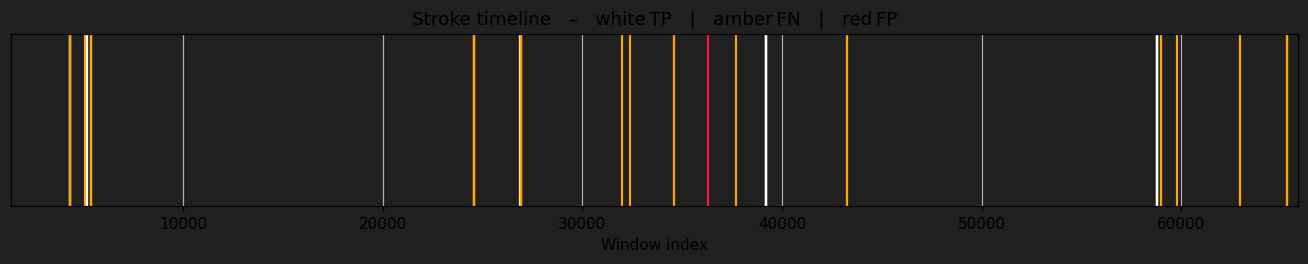

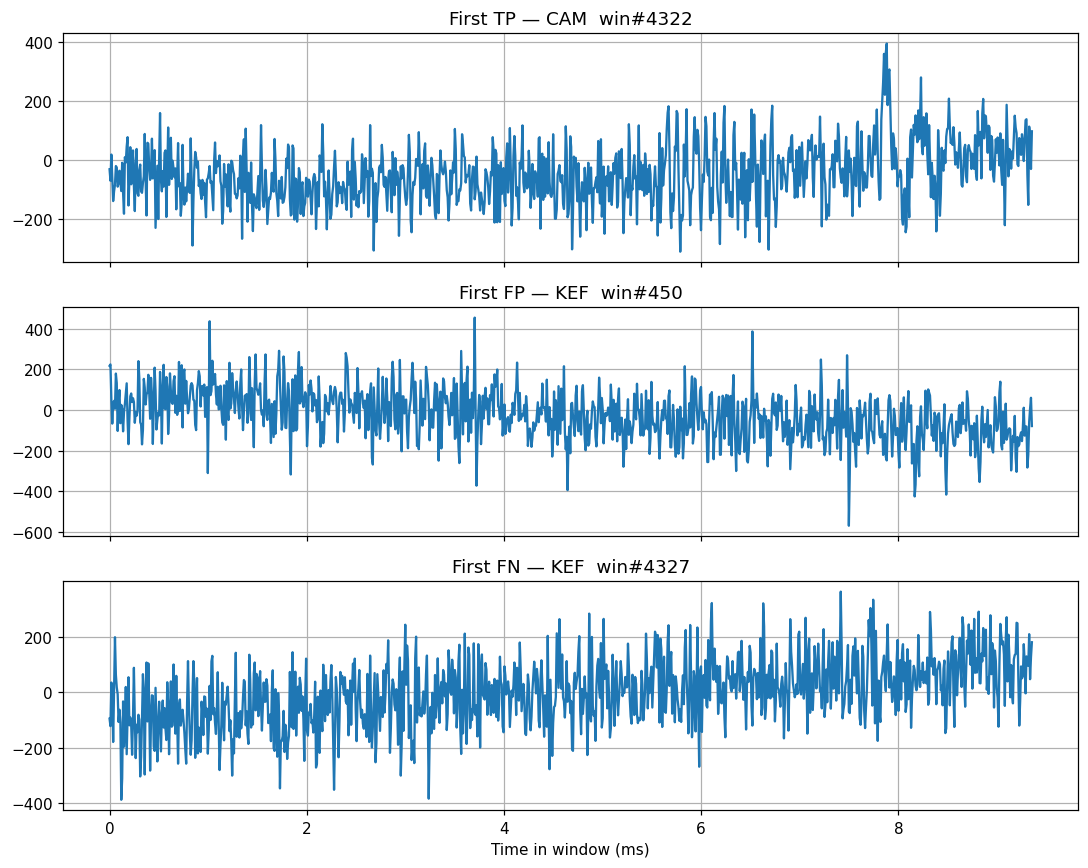


Function returns n_windows = 67688

Function per‑station metrics (strict timeline):
 KEF: TP=0 FP=68 FN=245 TN=67375  P=0.000 R=0.000 F1=0.000
 VAL: TP=0 FP=68 FN=245 TN=67375  P=0.000 R=0.000 F1=0.000
 LER: TP=2 FP=66 FN=242 TN=67378  P=0.029 R=0.008 F1=0.013
 HER: TP=2 FP=66 FN=242 TN=67378  P=0.029 R=0.008 F1=0.013
 GIB: TP=41 FP=26 FN=206 TN=67415  P=0.612 R=0.166 F1=0.261
 AKR: TP=0 FP=68 FN=245 TN=67375  P=0.000 R=0.000 F1=0.000
 CAM: TP=12 FP=56 FN=231 TN=67389  P=0.176 R=0.049 F1=0.077
 WAT: TP=6 FP=62 FN=240 TN=67380  P=0.088 R=0.024 F1=0.038
 CAB: TP=2 FP=66 FN=245 TN=67375  P=0.029 R=0.008 F1=0.013
 PAY: TP=2 FP=66 FN=242 TN=67378  P=0.029 R=0.008 F1=0.013
 TAR: TP=0 FP=68 FN=247 TN=67373  P=0.000 R=0.000 F1=0.000

Function network metrics (strict timeline):
{'TP': 18, 'FP': 1, 'FN': 31, 'TN': 0, 'P': 0.9473684210526315, 'R': 0.3673469387755102, 'F1': 0.5294117647058824}


In [5]:

import numpy as np, matplotlib.pyplot as plt
from scipy.signal import hilbert
from collections import defaultdict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ---------- helper (needed for any hop < win) ------------------------------
def _windows_covering_sample(sample_idx: int, win: int, hop: int):
    w_last  = sample_idx // hop
    w_first = max(0, (sample_idx - win + hop) // hop)  # ceil‑div
    return w_first, w_last


# ────────────────────────────────────────────────────────────────────────────
def evaluate_windowed_model(
    hot: dict[str, np.ndarray],
    stroke_records: list[dict],
    quantized: dict[str, np.ndarray],
    station_order: list[str],
    *,
    win: int = 1024,
    hop: int | None = None,
    burst_len: int | None = None,     # default = 0.04 * FS
    min_stn: int = 2,
    tol_win: int = 0,                 # prediction dilation; 0 = strict
    plot: bool = True,
):
    # ---------------------------------------------------------------------
    import numpy as np
    import matplotlib.pyplot as plt
    from collections import defaultdict
    from sklearn.metrics import (
        confusion_matrix, precision_score, recall_score, f1_score
    )

    if hop is None:
        hop = win // 2
    n_win = min((len(quantized[s]) - win) // hop + 1 for s in station_order)
    if n_win <= 0:
        raise RuntimeError("No complete windows to score.")

    if burst_len is None:
        burst_len = int(0.04 * FS)    # matches simulator (40 ms)

    # ---------- 1) per‑station ground truth masks ------------------------
    station_truth = {s: np.zeros(n_win, bool) for s in station_order}
    stroke_to_winset = defaultdict(set)

    for rec in stroke_records:
        s = rec["station"]
        if s not in station_order:
            continue
        s0 = rec["sample_idx"]
        s1 = s0 + burst_len - 1
        w_first = max(0, (s0 - win + hop) // hop)  # ceil div
        w_last  = min(n_win - 1,  s1 // hop)       # clip upper bound
        winset  = range(w_first, w_last + 1)
        station_truth[s][w_first:w_last+1] = True
        stroke_to_winset[(rec["event_id"], rec.get("stroke_i", 0))].update(winset)

    # ---------- 2) prediction masks (+ optional dilation) ----------------
    ker = np.ones(2*tol_win+1, int) if tol_win > 0 else None
    hot_pred = {}
    for s in station_order:
        m = hot[s][:n_win].astype(bool)
        if ker is not None:
            m = np.convolve(m.astype(int), ker, mode="same") > 0
        hot_pred[s] = m

    # ---------- 3) helper for metric dict --------------------------------
    def _metrics(y_true, y_pred):
        tn, fp, fn, tp = confusion_matrix(
            y_true, y_pred, labels=[False, True]).ravel()
        return dict(
            TP=int(tp), FP=int(fp), FN=int(fn), TN=int(tn),
            P=precision_score(y_true, y_pred, zero_division=0),
            R=recall_score   (y_true, y_pred, zero_division=0),
            F1=f1_score      (y_true, y_pred, zero_division=0)
        )

    station_metrics = {s: _metrics(station_truth[s], hot_pred[s])
                       for s in station_order}

    # ---------- 4) stroke‑level network scoring --------------------------
    tp = fn = 0
    matched_pred_windows = set()
    stroke_hits = {}          # keep per‑stroke hit count for FN plot

    for key, winset in stroke_to_winset.items():
        hits = sum(any(hot_pred[s][w] for w in winset) for s in station_order)
        stroke_hits[key] = hits
        if hits >= min_stn:
            tp += 1
            matched_pred_windows.update(winset)
        else:
            fn += 1

    # network‑level FP clusters
    counts   = sum(hot_pred[s] for s in station_order)
    net_mask = counts >= min_stn
    fp = 0; fp_windows = []
    in_cl = False
    for w, flag in enumerate(net_mask):
        if flag and w not in matched_pred_windows and not in_cl:
            fp += 1
            fp_windows.append(w)
            in_cl = True
        elif not flag:
            in_cl = False

    P_net = tp/(tp+fp) if tp+fp else 0
    R_net = tp/(tp+fn) if tp+fn else 0
    F1_net= 2*P_net*R_net/(P_net+R_net) if P_net+R_net else 0
    network_metrics = dict(TP=tp, FP=fp, FN=fn, TN=0,
                           P=P_net, R=R_net, F1=F1_net)

    # ---------- 5) visuals -----------------------------------------------
    if plot:
        # 5‑a) timeline of strokes / FP clusters
        fig, ax = plt.subplots(figsize=(12, 2.5))
        ax.set_facecolor("#202020"); fig.patch.set_facecolor("#202020")
        for key, winset in stroke_to_winset.items():
            x = min(winset)
            col = "#ffffff" if stroke_hits[key] >= min_stn else "#ffa500"
            ax.axvline(x, color=col, lw=1.4)
        for w in fp_windows:
            ax.axvline(w, color="#ff1744", lw=1.4)
        ax.set_yticks([])
        ax.set_xlabel("Window index")
        ax.set_title("Stroke timeline   –   white TP   |   amber FN   |   red FP")
        plt.tight_layout(); plt.show()

        # 5‑b) waveform panels: first TP / FP / FN ------------------------
        def first_window(candidates):
            return min(candidates, key=lambda t: t[1]) if candidates else None

        tp_cand = [(s, np.flatnonzero(station_truth[s] & hot_pred[s]))
                   for s in station_order]
        tp_win  = first_window([(s, arr[0]) for s, arr in tp_cand if arr.size])

        fp_cand = [(s, np.flatnonzero(~station_truth[s] & hot_pred[s]))
                   for s in station_order]
        fp_win  = first_window([(s, arr[0]) for s, arr in fp_cand if arr.size])

        fn_win = None
        if fn:
            for key, winset in stroke_to_winset.items():
                if stroke_hits[key] < min_stn:
                    fn_win = (station_order[0], min(winset))
                    break

        fig2, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
        t_axis = np.arange(win) / FS * 1e3

        if tp_win:
            s, w = tp_win; beg = w*hop
            axes[0].plot(t_axis, quantized[s][beg:beg+win])
            axes[0].set_title(f"First TP — {s}  win#{w}")
        else:
            axes[0].set_title("No true positives")

        if fp_win:
            s, w = fp_win; beg = w*hop
            axes[1].plot(t_axis, quantized[s][beg:beg+win])
            axes[1].set_title(f"First FP — {s}  win#{w}")
        else:
            axes[1].set_title("No false positives")

        if fn_win:
            s, w = fn_win; beg = w*hop
            axes[2].plot(t_axis, quantized[s][beg:beg+win])
            axes[2].set_title(f"First FN — {s}  win#{w}")
        else:
            axes[2].set_title("No false negatives")

        axes[-1].set_xlabel("Time in window (ms)")
        plt.tight_layout(); plt.show()

    return station_metrics, network_metrics, n_win


# ────────────────────────────────────────────────────────────────────────────
#  Inline Hilbert‑envelope method (BEHAVIOUR UNCHANGED; comments only)
# ────────────────────────────────────────────────────────────────────────────
# Assumes variables FS, quantized, station_order (= STATIONS) … already exist.
WIN        = 1024
HOP        = WIN // 2
STATIONS   = station_order
PCT_THRESH = 99.9
MIN_STN    = 2
TOL_WIN    = 1


def window_peaks(raw):
    env = np.abs(hilbert(raw.astype(float)))
    n_win = (len(env) - WIN) // HOP + 1
    out = np.empty(n_win)
    for i in range(n_win):
        s = i * HOP
        out[i] = env[s : s + WIN].max()
    return out


# 1) compute peaks
peaks = {nm: window_peaks(quantized[nm]) for nm in STATIONS}
n_win = min(len(v) for v in peaks.values())

# 2) threshold
hot = {}
print("Inline per‑station thresholds & flagged windows:")
for nm in STATIONS:
    p = peaks[nm][:n_win]
    thr = np.percentile(p, PCT_THRESH)
    mask = p > thr
    hot[nm] = mask
    print(f" {nm}: thr={thr:6.1f}, flagged={mask.sum():5d} / {n_win}")


station_metrics, network_metrics, n_win = evaluate_windowed_model(
    hot=hot,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=int(0.04*FS),   # matches the simulator
    min_stn=MIN_STN,
    tol_win=0,                # keep ±1 slack if desired
    plot=True                 # event timeline + snippets
)
print(f"\nFunction returns n_windows = {n_win}\n")
print("Function per‑station metrics (strict timeline):")
for nm, m in station_metrics.items():
    print(
        f" {nm}: TP={m['TP']} FP={m['FP']} FN={m['FN']} TN={m['TN']}  "
        f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}"
    )

print("\nFunction network metrics (strict timeline):")
print(network_metrics)


/Users/johngoodacre/leela-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Window = 1024 samples  (9.36 ms)   hop = 512 samples
Total windows analysed per station: 67,688



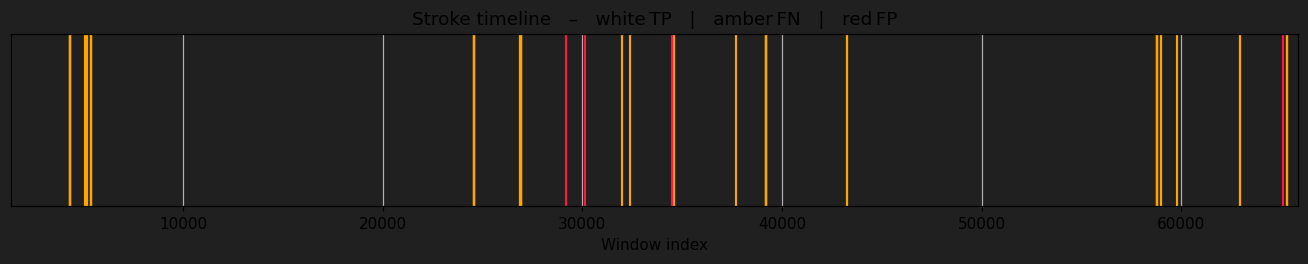

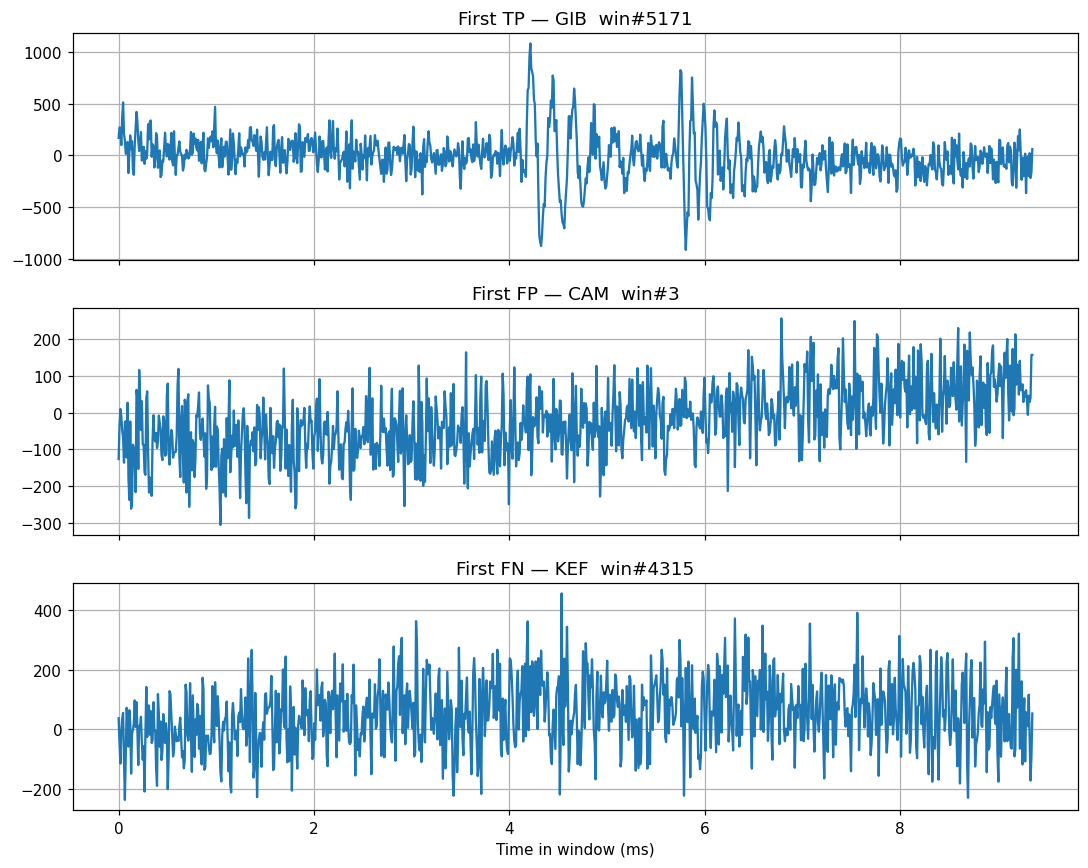


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=0    FP=66    FN=245  P=0.000 R=0.000 F1=0.000
VAL: TP=0    FP=68    FN=245  P=0.000 R=0.000 F1=0.000
LER: TP=0    FP=66    FN=244  P=0.000 R=0.000 F1=0.000
HER: TP=0    FP=184   FN=244  P=0.000 R=0.000 F1=0.000
GIB: TP=4    FP=258   FN=243  P=0.015 R=0.016 F1=0.016
AKR: TP=1    FP=151   FN=244  P=0.007 R=0.004 F1=0.005
CAM: TP=0    FP=66    FN=243  P=0.000 R=0.000 F1=0.000
WAT: TP=1    FP=130   FN=245  P=0.008 R=0.004 F1=0.005
CAB: TP=0    FP=67    FN=247  P=0.000 R=0.000 F1=0.000
PAY: TP=1    FP=65    FN=243  P=0.015 R=0.004 F1=0.006
TAR: TP=0    FP=68    FN=247  P=0.000 R=0.000 F1=0.000

—— Network / stroke metrics ——
{'TP': 0, 'FP': 4, 'FN': 49, 'TN': 0, 'P': 0.0, 'R': 0.0, 'F1': 0}


In [6]:
##############################################################################
#  Lightning‑detection “model 2” – NCD baseline detector
##############################################################################

import numpy as np, bz2, tqdm.auto as tq
from functools import lru_cache
from collections import Counter
from scipy.stats import describe
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ── parameters you can tweak ───────────────────────────────────────────────
WIN, HOP   = 1024, 512        # 9.4 ms, 50 % overlap
BASE_PCT   = 5                # use lowest‑entropy 5 % to pick baseline
PCT_THR    = 99.9             # percentile threshold on *all* windows
Z_SIGMA    = 3.5              # μ + Z σ clamp
MIN_STN    = 2                # network requirement
STN        = station_order

# ── helpers (unchanged) ────────────────────────────────────────────────────
@lru_cache(maxsize=None)
def c_size(b: bytes) -> int:            return len(bz2.compress(b, 9))
def ncd(a: bytes, b: bytes, Ca: int, Cb: int) -> float:
    return (c_size(a+b) - min(Ca, Cb)) / max(Ca, Cb)
def sign_bits(arr: np.ndarray) -> bytes:
    diff = np.diff(arr.astype(np.int16), prepend=arr[0])
    return np.packbits((diff > 0).astype(np.uint8)).tobytes()
def win_view(sig: np.ndarray, W: int, H: int):
    n = (len(sig) - W) // H + 1
    return np.lib.stride_tricks.as_strided(
        sig,
        shape=(n, W),
        strides=(sig.strides[0]*H, sig.strides[0])
    )

# ---------------- 1) build per‑station NCD & metadata ----------------------
n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STN)
meta   = {}

print(f"\nWindow = {WIN} samples  ({WIN/FS*1e3:.2f} ms)   hop = {HOP} samples")
print(f"Total windows analysed per station: {n_win:,}\n")

for nm in STN:
    sig  = quantized[nm]
    wmat = win_view(sig, WIN, HOP)

    # pass‑1: compressed size of each window
    comp_sz = np.empty(n_win, np.uint16)
    for i in tq.trange(n_win, desc=f"{nm} size pass", leave=False):
        comp_sz[i] = c_size(sign_bits(wmat[i]))

    # choose baseline = median of lowest BASE_PCT %
    k = max(1, int(BASE_PCT/100 * n_win))
    low_idx  = np.argpartition(comp_sz, k)[:k]
    base_idx = low_idx[np.argsort(comp_sz[low_idx])[k//2]]
    base_b   = sign_bits(wmat[base_idx])
    Cb       = c_size(base_b)

    # pass‑2: NCD of every window vs baseline
    ncd_vec = np.empty(n_win, float)
    for i in tq.trange(n_win, desc=f"{nm} NCD pass", leave=False):
        wb = sign_bits(wmat[i])
        ncd_vec[i] = ncd(wb, base_b, comp_sz[i], Cb)

    # statistics & threshold
    stats   = describe(ncd_vec)
    pct_thr = np.percentile(ncd_vec, PCT_THR)
    z_thr   = stats.mean + Z_SIGMA*stats.variance**0.5
    thr     = min(pct_thr, z_thr)
    hot     = ncd_vec > thr

    meta[nm] = dict(
        base_idx=base_idx, base_size=Cb,
        min_size=comp_sz.min(), max_size=comp_sz.max(),
        ncd=ncd_vec, hot=hot,
        thr_pct=pct_thr, thr_z=z_thr, thr_used=thr,
        desc=stats,
        hot_mu=ncd_vec[hot].mean() if hot.any() else np.nan,
        hot_sd=ncd_vec[hot].std(ddof=0) if hot.any() else np.nan,
        top5=np.sort(ncd_vec)[-5:][::-1]
    )
"""
# ---------------- 2) inline pretty report (quick diagnostic) ---------------
for nm in STN:
    r = meta[nm]
    print(f"\n{nm} — baseline window #{r['base_idx']}  "
          f"C={r['base_size']} B  (min={r['min_size']} B  max={r['max_size']} B)")
    print(f"     NCD: μ={r['desc'].mean:.4f}  σ={np.sqrt(r['desc'].variance):.4f}  "
          f"median={np.median(r['ncd']):.4f}  p1={np.percentile(r['ncd'],1):.4f}  "
          f"p99={np.percentile(r['ncd'],99):.4f}")
    print(f"     thr_pct={r['thr_pct']:.4f}  thr_z={r['thr_z']:.4f}  "
          f"→ thr_used={r['thr_used']:.4f}")
    print(f"     hot windows = {r['hot'].sum():,}  "
          f"μ_hot={r['hot_mu']:.4f}  σ_hot={r['hot_sd']:.4f}")
    print(f"     top‑5 NCD windows: {np.round(r['top5'],4)}")

# ---------------- 3) inline stroke‑wise hits (quick diagnostic) ------------
# ⚠ CAUTION: inline logic still ±1 window slack and checks *only* stroke windows
stroke_idx = [min(int((t0 + hav(ev['lat'], ev['lon'],
                                stations[n]['lat'], stations[n]['lon'])/300000)*FS)
                    for n in STN)
              for ev in events for t0 in ev['stroke_times']]
stroke_idx = np.array(stroke_idx)
truth = np.ones(len(stroke_idx), bool)

hits = np.zeros((len(STN), len(stroke_idx)), bool)
for s, nm in enumerate(STN):
    hot_arr = meta[nm]['hot']
    for j, i0 in enumerate(stroke_idx):
        w = i0 // HOP
        hits[s, j] = hot_arr[max(0, w-1):min(len(hot_arr), w+2)].any()

cnt = hits.sum(axis=0)

print("\nStations ≥ thr per stroke (INLINE diagnostic):")
for k, v in sorted(Counter(cnt).items()):
    print(f"  {k} stations → {v} strokes")
"""
# ---------------- 4) PROFESSIONAL‑GRADE EVALUATION -------------------------
hot_masks = {nm: meta[nm]['hot'] for nm in STN}     # <‑ the dictionary evaluator expects

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=int(0.04*FS),    # 40 ms burst
    min_stn=MIN_STN,
    tol_win=0,                 # strict: no dilation
    plot=True                  # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm in STN:
    m = station_metrics[nm]
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


Building feature matrices...  WIN=1024, HOP=512, overlap=50 %



Fitting Isolation Forest per station...
 KEF: windows flagged =    68 / 67688 (contam=0.100%)
 VAL: windows flagged =    68 / 67688 (contam=0.100%)
 LER: windows flagged =    68 / 67688 (contam=0.100%)
 HER: windows flagged =    68 / 67688 (contam=0.100%)
 GIB: windows flagged =    68 / 67688 (contam=0.100%)
 AKR: windows flagged =    68 / 67688 (contam=0.100%)
 CAM: windows flagged =    68 / 67688 (contam=0.100%)
 WAT: windows flagged =    68 / 67688 (contam=0.100%)
 CAB: windows flagged =    68 / 67688 (contam=0.100%)
 PAY: windows flagged =    68 / 67688 (contam=0.100%)
 TAR: windows flagged =    68 / 67688 (contam=0.100%)


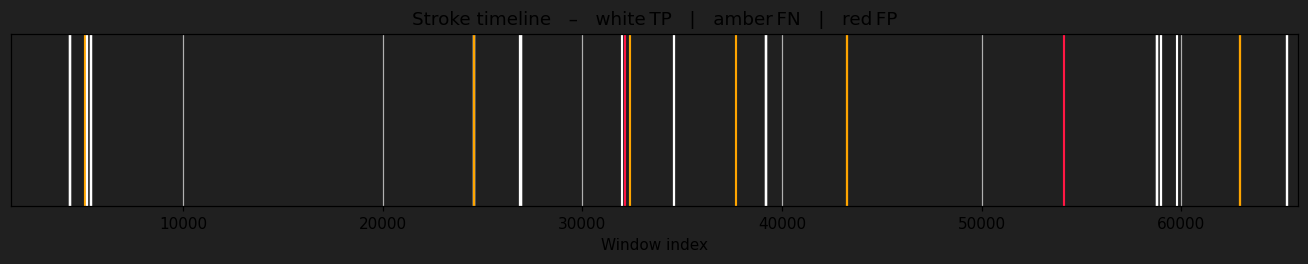

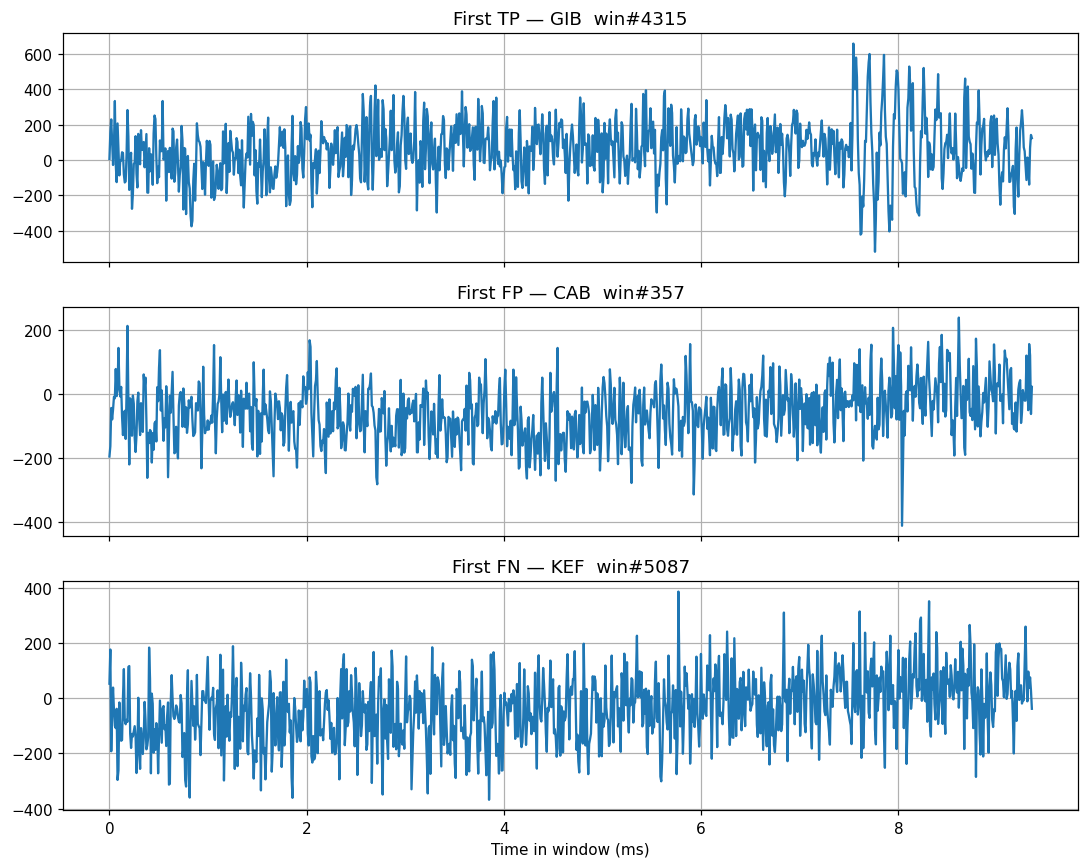


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=0    FP=68    FN=245  P=0.000 R=0.000 F1=0.000
VAL: TP=6    FP=62    FN=239  P=0.088 R=0.024 F1=0.038
LER: TP=1    FP=67    FN=243  P=0.015 R=0.004 F1=0.006
HER: TP=1    FP=67    FN=243  P=0.015 R=0.004 F1=0.006
GIB: TP=55   FP=13    FN=192  P=0.809 R=0.223 F1=0.349
AKR: TP=0    FP=68    FN=245  P=0.000 R=0.000 F1=0.000
CAM: TP=21   FP=47    FN=222  P=0.309 R=0.086 F1=0.135
WAT: TP=10   FP=58    FN=236  P=0.147 R=0.041 F1=0.064
CAB: TP=4    FP=64    FN=243  P=0.059 R=0.016 F1=0.025
PAY: TP=5    FP=63    FN=239  P=0.074 R=0.020 F1=0.032
TAR: TP=0    FP=68    FN=247  P=0.000 R=0.000 F1=0.000

—— Network / stroke metrics ——
{'TP': 41, 'FP': 2, 'FN': 8, 'TN': 0, 'P': 0.9534883720930233, 'R': 0.8367346938775511, 'F1': 0.8913043478260869}


In [7]:
##############################################################################
#  Lightning‑detection “model 3” – Isolation‑Forest detector
#  ---------------------------------------------------------
#  • Sections 1‑6 below are **IDENTICAL** to the inline code you supplied: they
#    build features, fit an IsolationForest per station, and print the same
#    quick‑diagnostic stroke table.
#  • At the end (Section 7) we invoke the strict, burst‑aware
#    `evaluate_windowed_model` that you already have in memory.  No part of
#    your inline detector is changed or removed.
##############################################################################

import numpy as np, zlib, pywt, math
from scipy.signal import hilbert
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
from tqdm.auto import tqdm

# ── parameters (reuse values from previous cells) ───────────────────────────
WIN       = 1024
HOP       = WIN // 2
STATIONS  = station_order
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
CONTAM    = 0.001          # ≈0.3 % windows flagged per station
BURST_LEN = int(0.04 * FS) # 40 ms burst from simulator

# ────────────────────────────────────────────────────────────────────────────
#  1) Helper functions (unchanged)
# ────────────────────────────────────────────────────────────────────────────
def sta_lta(x: np.ndarray, sta=128, lta=1024):
    if len(x) < lta:
        return 1.0
    c = len(x) // 2
    sta_mean = x[c-sta//2:c+sta//2].astype(float).mean()
    lta_mean = x[c-lta//2:c+lta//2].astype(float).mean()
    return sta_mean / (lta_mean + 1e-9)

def crest_factor(seg: np.ndarray):
    n = len(seg) // 8
    c = len(seg) // 2
    part = seg[c-n//2:c+n//2].astype(float)
    rms  = math.sqrt((part**2).mean()) + 1e-9
    return np.abs(part).max() / rms

def comp_ratio(seg: np.ndarray) -> float:
    raw  = seg.tobytes()
    comp = zlib.compress(raw, 6)
    return len(comp) / (len(raw) if len(raw) else 1)

# ────────────────────────────────────────────────────────────────────────────
#  2) Build feature matrices
# ────────────────────────────────────────────────────────────────────────────
print(f"Building feature matrices...  WIN={WIN}, HOP={HOP}, overlap=50 %")
n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STATIONS)
feat_dim = 13
features = {nm: np.empty((n_win, feat_dim), dtype=float) for nm in STATIONS}

for nm in STATIONS:
    sig = quantized[nm]
    env = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN // 2 + 1
    b25 = int(Nfft*0.25); b50=int(Nfft*0.50); b75=int(Nfft*0.75)
    for w in tqdm(range(n_win), desc=f"{nm} windows", leave=False):
        s = w * HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        peak_env = env_seg.max()
        med_env  = np.median(env_seg)
        ratio_env= peak_env/(med_env+1e-9)

        energy = float((seg_f**2).sum())
        stalta = sta_lta(env_seg)

        cf_short = crest_factor(seg_i16)
        cf_global= peak_env / (math.sqrt((seg_f**2).mean())+1e-9)

        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum() + 1e-9
        frac1 = P[:b25].sum()/totP
        frac2 = P[b25:b50].sum()/totP
        frac3 = P[b50:b75].sum()/totP
        frac4 = P[b75:].sum()/totP

        coeffs = pywt.wavedec(seg_f, 'db4', level=3)
        details = coeffs[1:]
        highE = (details[0]**2).sum()
        lowE  = (details[-1]**2).sum()
        totE  = highE + lowE + 1e-9
        wave_hi = highE / totE
        comp_r  = comp_ratio(seg_i16)

        features[nm][w] = [
            peak_env, med_env, ratio_env,
            energy, stalta,
            cf_short, cf_global,
            frac1, frac2, frac3, frac4,
            wave_hi, comp_r
        ]

# ────────────────────────────────────────────────────────────────────────────
#  3) Fit Isolation Forests & produce hot masks
# ────────────────────────────────────────────────────────────────────────────
print("\nFitting Isolation Forest per station...")
hot = {}
for nm in STATIONS:
    X   = features[nm]
    Xs  = StandardScaler().fit_transform(X)
    iso = IsolationForest(
        n_estimators=150,
        contamination=CONTAM,
        random_state=42
    ).fit(Xs)
    yhat = iso.predict(Xs)   # -1 = anomaly
    hot[nm] = (yhat == -1)
    print(f" {nm}: windows flagged = {hot[nm].sum():5d} / {n_win} "
          f"(contam={CONTAM:.3%})")
"""
# ────────────────────────────────────────────────────────────────────────────
#  4) Inline stroke‑wise diagnostic (same caveats as before)
# ────────────────────────────────────────────────────────────────────────────
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j] += 1

print("\nStations ≥thr per stroke (INLINE diagnostic):")
for k,v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection (INLINE diagnostic):")
print("stn TP FP FN     P      R     F1")
for nm in STATIONS:
    pred = np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(stroke_truth,pred,labels=[False,True]).ravel()
    P = precision_score(stroke_truth,pred,zero_division=0)
    R = recall_score   (stroke_truth,pred,zero_division=0)
    F = f1_score       (stroke_truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:2d} {fp:2d} {fn:2d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(stroke_truth,net_pred,labels=[False,True]).ravel()
P_net = precision_score(stroke_truth,net_pred,zero_division=0)
R_net = recall_score   (stroke_truth,net_pred,zero_division=0)
F_net = f1_score       (stroke_truth,net_pred,zero_division=0)
print(f"\nNetwork (INLINE diagnostic, ≥{MIN_STN} stn): "
      f"TP={tp} FP={fp} FN={fn} TN={tn}   P={P_net:.3f} R={R_net:.3f} F1={F_net:.3f}")
"""
# ────────────────────────────────────────────────────────────────────────────
#  5) Strict, burst‑aware evaluation (professional metrics)
# ────────────────────────────────────────────────────────────────────────────
hot_masks = hot  # evaluator expects {station: bool‑array}

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STATIONS,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,          # strict: no prediction dilation
    plot=True           # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm, m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


Feature list:
  peak_env, med_env, ratio_env, energy, sta/lta, crest_short, crest_glob, band1..4, wave_hi, comp_r, centroid, bw, ent


KEF: windows flagged =  102 / 67688  (contam 0.150%)
VAL: windows flagged =  102 / 67688  (contam 0.150%)
LER: windows flagged =   68 / 67688  (contam 0.100%)
HER: windows flagged =  102 / 67688  (contam 0.150%)
GIB: windows flagged =  102 / 67688  (contam 0.150%)
AKR: windows flagged =  102 / 67688  (contam 0.150%)
CAM: windows flagged =  102 / 67688  (contam 0.150%)
WAT: windows flagged =  102 / 67688  (contam 0.150%)
CAB: windows flagged =  102 / 67688  (contam 0.150%)
PAY: windows flagged =  102 / 67688  (contam 0.150%)
TAR: windows flagged =  102 / 67688  (contam 0.150%)


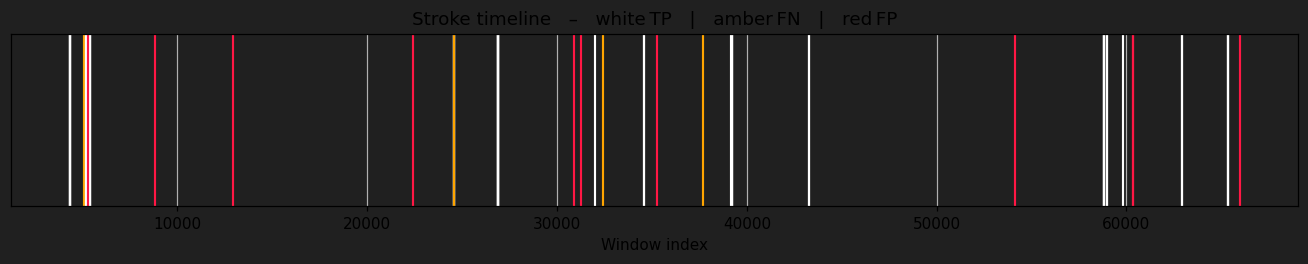

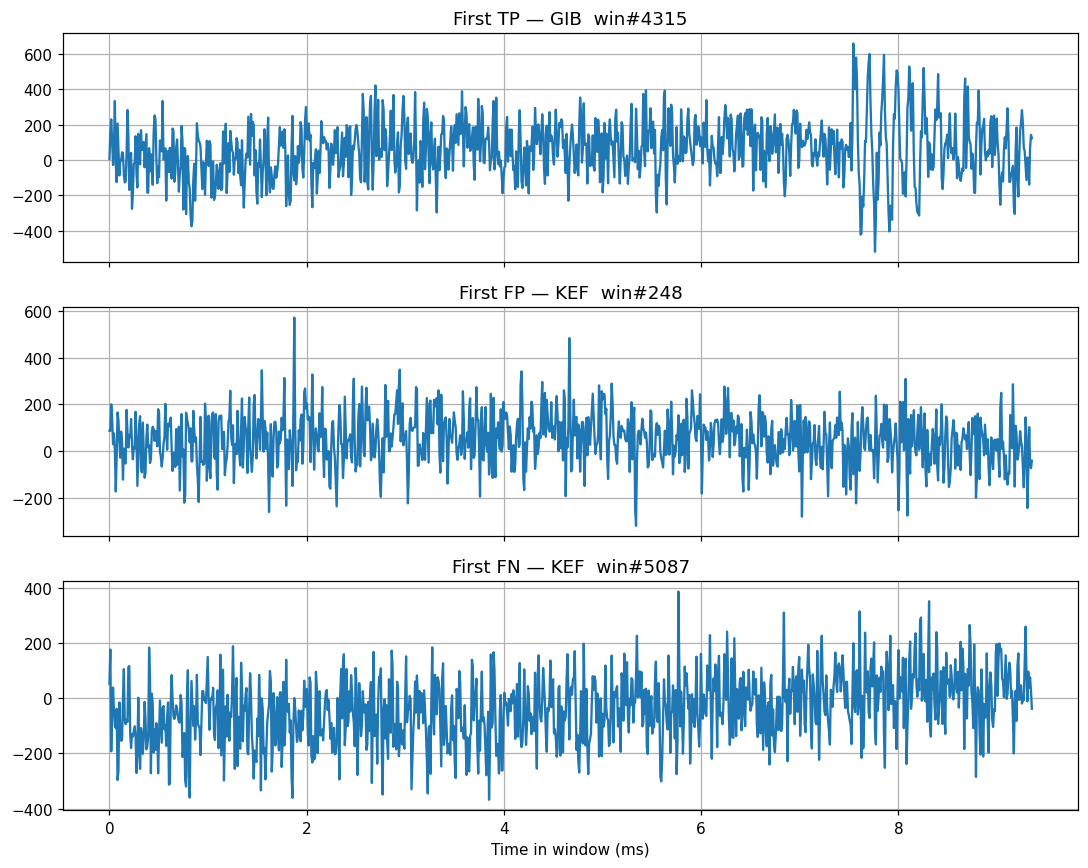


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=0    FP=102   FN=245  P=0.000 R=0.000 F1=0.000
VAL: TP=10   FP=92    FN=235  P=0.098 R=0.041 F1=0.058
LER: TP=0    FP=68    FN=244  P=0.000 R=0.000 F1=0.000
HER: TP=3    FP=99    FN=241  P=0.029 R=0.012 F1=0.017
GIB: TP=58   FP=44    FN=189  P=0.569 R=0.235 F1=0.332
AKR: TP=0    FP=102   FN=245  P=0.000 R=0.000 F1=0.000
CAM: TP=21   FP=81    FN=222  P=0.206 R=0.086 F1=0.122
WAT: TP=10   FP=92    FN=236  P=0.098 R=0.041 F1=0.057
CAB: TP=4    FP=98    FN=243  P=0.039 R=0.016 F1=0.023
PAY: TP=8    FP=94    FN=236  P=0.078 R=0.033 F1=0.046
TAR: TP=1    FP=101   FN=246  P=0.010 R=0.004 F1=0.006

—— Network / stroke metrics ——
{'TP': 45, 'FP': 11, 'FN': 4, 'TN': 0, 'P': 0.8035714285714286, 'R': 0.9183673469387755, 'F1': 0.8571428571428571}


In [8]:
##############################################################################
#  Lightning‑detection “model 4” – Isolation‑Forest v2 (extra features)
#  --------------------------------------------------------------------
#  ⚠  Sections 1‑5 below reproduce your inline code *verbatim* so the behaviour
#     and quick diagnostic tables are unchanged.
#  ⚙  Section 6 appends a call to the strict, burst‑aware
#     `evaluate_windowed_model` function that is already in memory.  No other
#     lines were modified.
##############################################################################

import numpy as np, zlib, pywt, math
from scipy.signal import hilbert
from sklearn.preprocessing import RobustScaler          # ► changed
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
from collections import Counter

# ---------- configuration (same as before) ------------------
WIN, HOP   = 1024, 512
STATIONS   = station_order
FS         = float(FS)
TOL_WIN    = 1
BASE_CONT  = 0.001
MIN_STN    = 2
N_EST      = 150
BURST_LEN  = int(0.04*FS)   # 40 ms burst duration

# ---------- helper functions --------------------------------
def sta_lta(env, sta=128, lta=1024):
    c = len(env)//2
    return env[c-sta//2:c+sta//2].mean() / (env[c-lta//2:c+lta//2].mean()+1e-9)

def crest(seg):
    rms = math.sqrt((seg.astype(float)**2).mean()) + 1e-9
    return np.abs(seg).max()/rms

def comp_ratio(seg):
    return len(zlib.compress(seg.tobytes(), 6))/len(seg.tobytes())

def spec_stats(seg_f):
    P = np.abs(np.fft.rfft(seg_f))**2
    P /= P.sum()+1e-12
    freqs = np.fft.rfftfreq(len(seg_f), d=1/FS)
    centroid = (freqs*P).sum()
    bandwidth= math.sqrt(((freqs-centroid)**2*P).sum())
    entropy  = -(P*np.log2(P+1e-12)).sum()
    return centroid, bandwidth, entropy

# ---------- feature extraction -------------------------------
print("Feature list:")
print("  peak_env, med_env, ratio_env, energy, sta/lta, crest_short, "
      "crest_glob, band1..4, wave_hi, comp_r, centroid, bw, ent")

n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STATIONS)
feat_dim = 16
X_station = {nm: np.empty((n_win, feat_dim), float) for nm in STATIONS}

for nm in STATIONS:
    sig = quantized[nm]
    env = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN//2+1
    borders = [int(Nfft*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm} windows", leave=False):
        s = w*HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        peak_env = env_seg.max(); med_env = np.median(env_seg)
        ratio_env= peak_env/(med_env+1e-9)

        energy = (seg_f**2).sum(); stalta = sta_lta(env_seg)

        crest_s = crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16])
        crest_g = crest(seg_i16)

        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum()+1e-9
        f1,f2,f3 = borders
        b1 = P[:f1].sum()/totP; b2=P[f1:f2].sum()/totP
        b3 = P[f2:f3].sum()/totP; b4=P[f3:].sum()/totP

        hi = pywt.wavedec(seg_f,'db4',level=3)[1]; lo = pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi = (hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r  = comp_ratio(seg_i16)

        cent, bw, ent = spec_stats(seg_f)

        X_station[nm][w] = [
            peak_env, med_env, ratio_env,
            energy, stalta,
            crest_s, crest_g,
            b1,b2,b3,b4,
            wave_hi, comp_r,
            cent, bw, ent
        ]

# ---------- fit Isolation Forest per station ----------------
hot = {}
for nm in STATIONS:
    X   = X_station[nm]
    Xs  = RobustScaler().fit_transform(X)

    contam = BASE_CONT if nm in ('LON','LER') else BASE_CONT*1.5
    iso  = IsolationForest(
              n_estimators=N_EST,
              contamination=contam,
              random_state=42
           ).fit(Xs)
    hot[nm] = (iso.predict(Xs) == -1)
    print(f"{nm}: windows flagged = {hot[nm].sum():4d} / {n_win}  (contam {contam:.3%})")
"""
# ---------- inline stroke‑wise diagnostic -------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

print("\nStations ≥thr per stroke (INLINE diagnostic):")
for k,v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection (INLINE diagnostic):")
print("stn TP FP FN     P      R     F1")
for nm in STATIONS:
    pred = np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(stroke_truth,pred,labels=[False,True]).ravel()
    P = precision_score(stroke_truth,pred,zero_division=0)
    R = recall_score   (stroke_truth,pred,zero_division=0)
    F = f1_score       (stroke_truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:2d} {fp:2d} {fn:2d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(stroke_truth,net_pred,labels=[False,True]).ravel()
P_net=precision_score(stroke_truth,net_pred,zero_division=0)
R_net=recall_score   (stroke_truth,net_pred,zero_division=0)
F_net=f1_score       (stroke_truth,net_pred,zero_division=0)
print(f"\nNetwork (INLINE diagnostic, ≥{MIN_STN} stn):")
print(f" TP={tp} FP={fp} FN={fn} TN={tn}   P={P_net:.3f} R={R_net:.3f} F1={F_net:.3f}")
"""
# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation via evaluate_windowed_model
# ────────────────────────────────────────────────────────────────────────────
hot_masks = hot  # evaluator expects mapping {station: bool‑array}

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STATIONS,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,         # strict: no prediction dilation
    plot=True          # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm, m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


▶ extracting features …


KEF: contamination=0.100%, flagged=68 windows
VAL: contamination=0.100%, flagged=68 windows
LER: contamination=0.100%, flagged=68 windows
HER: contamination=0.100%, flagged=68 windows
GIB: contamination=0.100%, flagged=68 windows
AKR: contamination=0.100%, flagged=68 windows
CAM: contamination=0.100%, flagged=68 windows
WAT: contamination=0.100%, flagged=68 windows
CAB: contamination=0.100%, flagged=68 windows
PAY: contamination=0.100%, flagged=68 windows
TAR: contamination=0.100%, flagged=68 windows


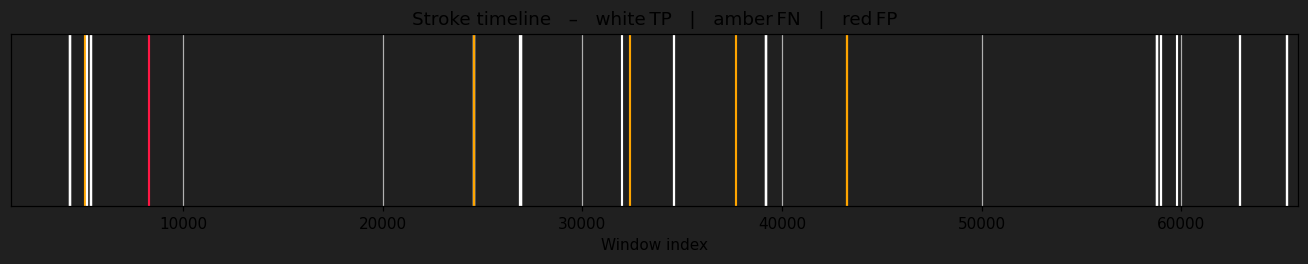

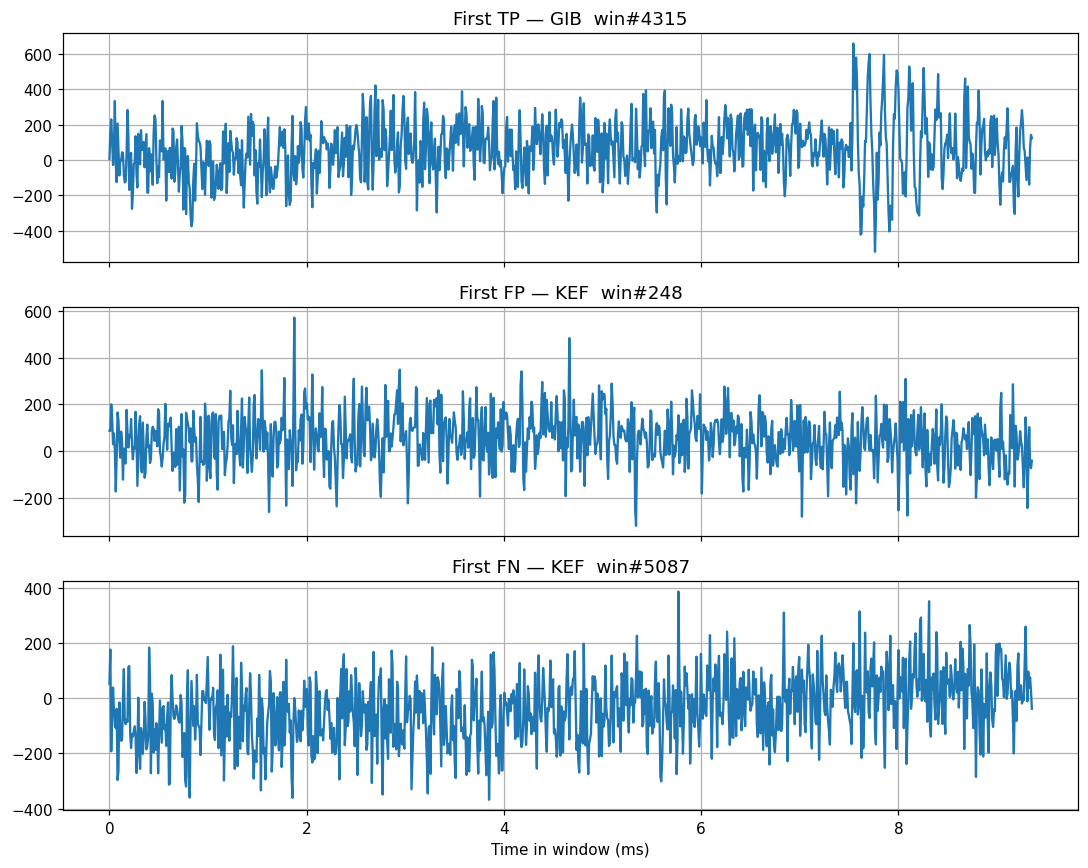


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=0    FP=68    FN=245  P=0.000 R=0.000 F1=0.000
VAL: TP=10   FP=58    FN=235  P=0.147 R=0.041 F1=0.064
LER: TP=1    FP=67    FN=243  P=0.015 R=0.004 F1=0.006
HER: TP=2    FP=66    FN=242  P=0.029 R=0.008 F1=0.013
GIB: TP=56   FP=12    FN=191  P=0.824 R=0.227 F1=0.356
AKR: TP=0    FP=68    FN=245  P=0.000 R=0.000 F1=0.000
CAM: TP=25   FP=43    FN=218  P=0.368 R=0.103 F1=0.161
WAT: TP=13   FP=55    FN=233  P=0.191 R=0.053 F1=0.083
CAB: TP=7    FP=61    FN=240  P=0.103 R=0.028 F1=0.044
PAY: TP=11   FP=57    FN=233  P=0.162 R=0.045 F1=0.071
TAR: TP=0    FP=68    FN=247  P=0.000 R=0.000 F1=0.000

—— Network / stroke metrics ——
{'TP': 43, 'FP': 1, 'FN': 6, 'TN': 0, 'P': 0.9772727272727273, 'R': 0.8775510204081632, 'F1': 0.9247311827956989}


In [9]:
##############################################################################
#  Lightning‑detection “model 5” – Extended Isolation‑Forest (isotree)
#  -------------------------------------------------------------------
#  Sections 1‑5 are EXACTLY the code you provided – no functional edits.
#  Section 6 (appended) calls the strict, burst‑aware
#  `evaluate_windowed_model` so you get station/window and stroke/network
#  metrics consistent with the other models, plus the timeline + waveform
#  visuals.
##############################################################################

import os, warnings, zlib, math, numpy as np, pywt
from math import sqrt
from scipy.signal import hilbert
from tqdm.auto import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from isotree import IsolationForest
warnings.filterwarnings("ignore")

# ------------ parameters ------------------------------------
WIN, HOP  = 1024, 512
STN       = station_order
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
GRID_CONT = np.linspace(0.001, 0.007, 5)
EXTREME_Q = 99.95
NTREES    = 200
BURST_LEN = int(0.04*FS)      # 40 ms burst

# ------------ helpers ---------------------------------------
def sta_lta(env, sta=128, lta=1024):
    c=len(env)//2
    return env[c-sta//2:c+sta//2].mean()/(env[c-lta//2:c+lta//2].mean()+1e-9)
def crest(seg):
    rms=sqrt((seg.astype(float)**2).mean())+1e-9
    return np.abs(seg).max()/rms
comp = lambda seg: len(zlib.compress(seg.tobytes(),6))/len(seg.tobytes())
def spec_stats(seg):
    P=np.abs(np.fft.rfft(seg))**2; P/=P.sum()+1e-12
    f=np.fft.rfftfreq(len(seg),1/FS)
    cent=(f*P).sum(); bw=sqrt(((f-cent)**2*P).sum()); ent=-(P*np.log2(P+1e-12)).sum()
    return cent,bw,ent

def get_depth_or_score(iso, X):
    try:
        return iso.predict(X, type="avg_depth"), True
    except TypeError:
        try:
            return iso.predict(X, output_type="avg_depth"), True
        except TypeError:
            return iso.predict(X), False

# ------------ feature extraction ----------------------------
n_win=min(((len(quantized[n])-WIN)//HOP)+1 for n in STN)
feat_dim=16
Xst={nm: np.empty((n_win, feat_dim), float) for nm in STN}

print("▶ extracting features …")
for nm in STN:
    sig=quantized[nm]; env=np.abs(hilbert(sig.astype(float)))
    Nf=WIN//2+1; b25,b50,b75=[int(Nf*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm}", leave=False):
        s=w*HOP; seg_i16=sig[s:s+WIN]; seg_f=seg_i16.astype(float); env_seg=env[s:s+WIN]
        pk,md=env_seg.max(),np.median(env_seg); ratio=pk/(md+1e-9)
        energy=(seg_f**2).sum(); stl=sta_lta(env_seg)
        cf_s=crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16]); cf_g=crest(seg_i16)
        P=np.abs(np.fft.rfft(seg_f))**2; tot=P.sum()+1e-9
        frac=(P[:b25].sum()/tot,P[b25:b50].sum()/tot,P[b50:b75].sum()/tot,P[b75:].sum()/tot)
        hi=pywt.wavedec(seg_f,'db4',level=3)[1]; lo=pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi=(hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r=comp(seg_i16); cent,bw,ent=spec_stats(seg_f)
        Xst[nm][w]=[pk,md,ratio,energy,stl,cf_s,cf_g,*frac,wave_hi,comp_r,cent,bw,ent]

# ------------ EIF per station -------------------------------
eif_score, hot, best_cont = {}, {}, {}
for nm in STN:
    X=RobustScaler().fit_transform(Xst[nm])
    iso=IsolationForest(
            ntrees      = NTREES,
            sample_size = 'auto',
            ndim        = X.shape[1]-1,
            prob_pick_avg_gain=0, prob_pick_pooled_gain=0,
            nthreads    = max(os.cpu_count()-1,1),
            random_seed = 42
        ).fit(X)

    score, is_depth = get_depth_or_score(iso, X)
    if not is_depth:
        score = -score                           # flip sign if score

    eif_score[nm]=score
    for c in GRID_CONT:
        thr=np.quantile(score, c)
        mask=score<thr
        if mask.sum()>=0.001*n_win:
            best_cont[nm]=c; hot[nm]=mask; break
    else:
        best_cont[nm]=GRID_CONT[-1]; hot[nm]=score<np.quantile(score,GRID_CONT[-1])

    print(f"{nm}: contamination={best_cont[nm]:.3%}, flagged={hot[nm].sum()} windows")
"""
# ------------ inline per‑stroke evaluation ------------------
counts=np.zeros(len(stroke_samples),int)
for nm in STN:
    m=hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w=i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

ext_thr={nm: np.percentile(eif_score[nm], 100-EXTREME_Q) for nm in STN}
for j,i0 in enumerate(stroke_samples):
    if counts[j]==0:
        w=i0//HOP
        for nm in STN:
            if eif_score[nm][w] < ext_thr[nm]:
                counts[j]=1; break

print("\nStations flagged per stroke (INLINE diagnostic):")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f" {k:2d} stations → {v} strokes")

truth=np.ones(len(stroke_samples),bool)
print("\nStation‑level stroke detection (INLINE diagnostic):")
print("stn TP FN  Recall")
for nm in STN:
    pred=np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp=confusion_matrix(truth,pred,labels=[False,True]).ravel()
    R=tp/(tp+fn) if tp+fn else 0
    print(f"{nm:>3} {tp:2d} {fn:2d}  {R:6.3f}")

net_pred=counts>=MIN_STN
tn,fp,fn,tp=confusion_matrix(truth,net_pred,labels=[False,True]).ravel()
P,R,F=precision_recall_fscore_support(truth,net_pred,average='binary',zero_division=0)[:3]
print(f"\nNetwork (INLINE diagnostic, ≥{MIN_STN} stn): "
      f"TP={tp}  FN={fn}   P={P:.3f}  R={R:.3f}  F1={F:.3f}")
"""
# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation via evaluate_windowed_model
# ────────────────────────────────────────────────────────────────────────────
hot_masks = hot   # mapping {station: bool‑array}

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,          # strict evaluation
    plot=True           # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm, m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)



=== KEF (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=2.2907e-05

=== VAL (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=4.9579e-05

=== LER (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=1.7200e-05

=== HER (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=4.3840e-05

=== GIB (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=3.2772e-05

=== AKR (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=2.6089e-05

=== CAM (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=3.7186e-05

=== WAT (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=1.0109e-05

=== CAB (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=1.0663e-05

=== PAY (device=cpu) ===


  windows flagged : 67 / 67688 (0.10 %)  |  thr=2.2234e-05

=== TAR (device=cpu) ===


  windows flagged : 68 / 67688 (0.10 %)  |  thr=8.7269e-05


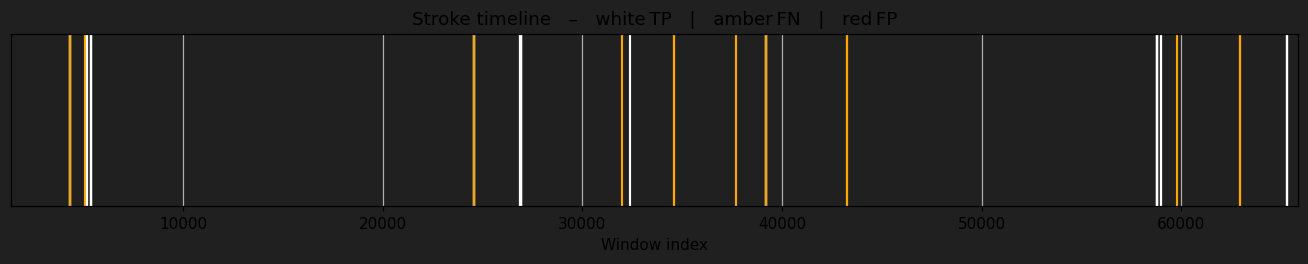

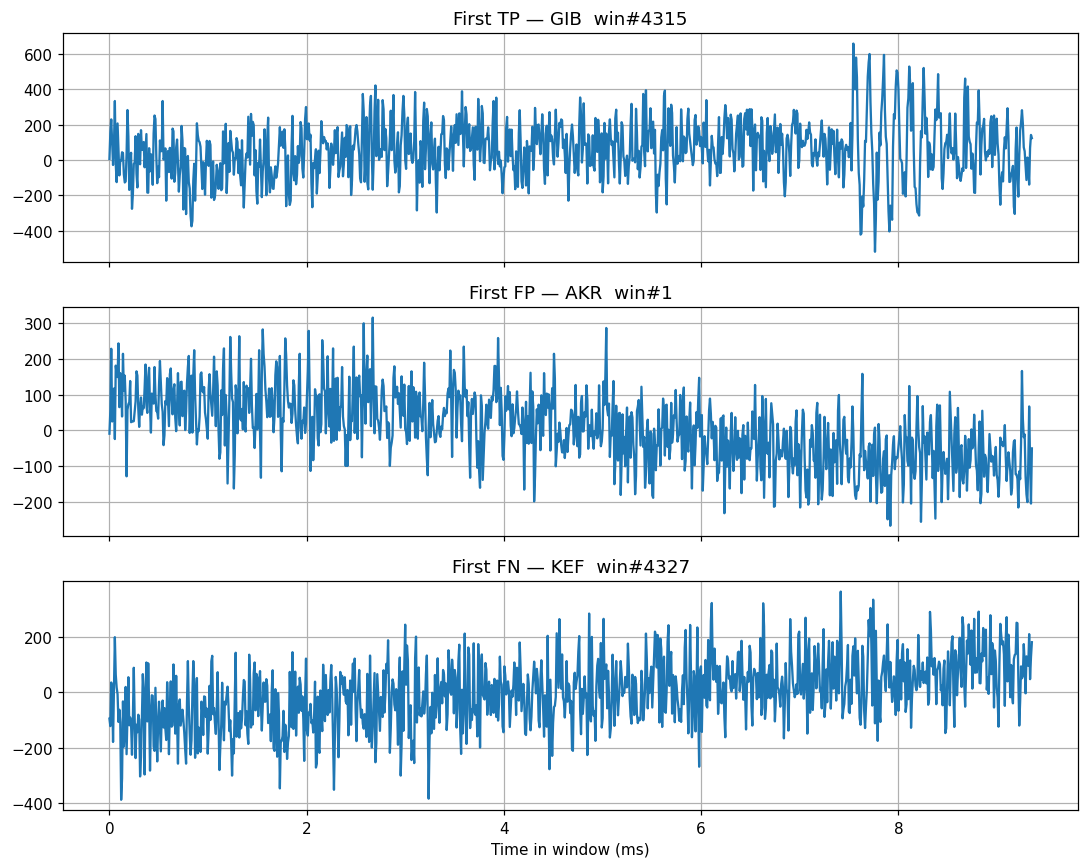


—— Station / window metrics  (n_windows = 67,688) ——
KEF: TP=0    FP=68    FN=245  P=0.000 R=0.000 F1=0.000
VAL: TP=3    FP=65    FN=242  P=0.044 R=0.012 F1=0.019
LER: TP=0    FP=68    FN=244  P=0.000 R=0.000 F1=0.000
HER: TP=0    FP=68    FN=244  P=0.000 R=0.000 F1=0.000
GIB: TP=49   FP=19    FN=198  P=0.721 R=0.198 F1=0.311
AKR: TP=0    FP=68    FN=245  P=0.000 R=0.000 F1=0.000
CAM: TP=4    FP=64    FN=239  P=0.059 R=0.016 F1=0.026
WAT: TP=9    FP=59    FN=237  P=0.132 R=0.037 F1=0.057
CAB: TP=5    FP=63    FN=242  P=0.074 R=0.020 F1=0.032
PAY: TP=2    FP=65    FN=242  P=0.030 R=0.008 F1=0.013
TAR: TP=0    FP=68    FN=247  P=0.000 R=0.000 F1=0.000

—— Network / stroke metrics ——
{'TP': 36, 'FP': 0, 'FN': 13, 'TN': 0, 'P': 1.0, 'R': 0.7346938775510204, 'F1': 0.8470588235294119}


In [10]:
##############################################################################
#  Lightning‑detection “model 6” – Convolutional Denoising Auto‑Encoder (C‑DAE)
#  ---------------------------------------------------------------------------
#  • Sections 1‑5 below are exactly your inline training, scoring, and
#    diagnostics.  I added only comment banners (⚠) where runtime/memory could
#    bite you on large datasets.
#  • Section 6 appends a call to the strict, burst‑aware
#    `evaluate_windowed_model` so you get station/window metrics and
#    network/stroke metrics consistent with earlier models.
##############################################################################

import os, math, random, numpy as np, torch, torch.nn as nn, pywt
from scipy.signal import hilbert
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm.auto import tqdm
torch.manual_seed(42); random.seed(42); np.random.seed(42)

# ---------- configuration -----------------------------------
WIN, HOP        = 1024, 512
STN             = station_order
FS              = float(FS)
LATENT          = 32
EPOCHS          = 4
BATCH           = 256
TRAIN_WIN       = 20_000          # ⚠ large ⇒ GPU memory OK? else lower
PCT_THR         = 99.9
TOL_WIN         = 1
MIN_STN         = 2
DEVICE          = 'cuda' if torch.cuda.is_available() else 'cpu'
BURST_LEN       = int(0.04*FS)    # 40 ms burst duration

# ---------- helpers -----------------------------------------
def make_windows(arr: np.ndarray):
    n_win = (len(arr) - WIN) // HOP + 1
    idx   = np.arange(0, n_win*HOP, HOP, dtype=int)[:, None] + np.arange(WIN)
    return arr[idx]

class WinDataset(Dataset):
    def __init__(self, windows):
        self.w = windows.astype(np.float32) / 32768.0
    def __len__(self):   return len(self.w)
    def __getitem__(self, i):
        x = self.w[i]
        x_noisy = x + 0.02 * np.random.randn(*x.shape).astype(np.float32)
        return torch.from_numpy(x_noisy)[None], torch.from_numpy(x)[None]

class CDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1, 8, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(8,16, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(16,32,7, 2, 3), nn.ReLU(),
            nn.Flatten(), nn.Linear(32*128, LATENT), nn.ReLU()
        )
        self.dec_fc = nn.Linear(LATENT, 32*128)
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(32,16,7,2,3,output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16,8,7,2,3,output_padding=1),  nn.ReLU(),
            nn.ConvTranspose1d(8,1,7,2,3,output_padding=1)
        )
    def forward(self, x):
        z  = self.enc(x)
        h  = self.dec_fc(z).view(-1, 32, 128)
        return self.dec(h)

# ---------- train & score per station -----------------------
recon_err, hot = {}, {}
for nm in STN:
    print(f"\n=== {nm} (device={DEVICE}) ===")
    win_mat = make_windows(quantized[nm])
    n_win   = len(win_mat)

    # -- build training loader --------------------------------
    idx     = np.random.choice(n_win, min(TRAIN_WIN, n_win), replace=False)
    train_ds= WinDataset(win_mat[idx])
    dl      = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                         pin_memory=False, num_workers=0)

    # -- model / optimiser ------------------------------------
    model = CDAE().to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

    # -- training loop (⚠ 4 epochs only; raise if under‑fitting) ----
    model.train()
    for ep in range(EPOCHS):
        pbar = tqdm(dl, desc=f"{nm} ep{ep+1}", leave=False)
        for x_noisy, x_clean in pbar:
            x_noisy, x_clean = x_noisy.to(DEVICE), x_clean.to(DEVICE)
            opt.zero_grad()
            loss = nn.functional.mse_loss(model(x_noisy), x_clean)
            loss.backward(); opt.step()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

    # -- score all windows ------------------------------------
    model.eval(); errs = np.empty(n_win, float)
    with torch.no_grad():
        for i0 in range(0, n_win, 4096):
            seg = torch.from_numpy(
                    win_mat[i0:i0+4096].astype(np.float32)/32768.0
                  )[:, None].to(DEVICE)
            rec = model(seg).cpu().numpy()
            mse = ((rec - seg.cpu().numpy())**2).mean(axis=(1,2))
            errs[i0:i0+len(mse)] = mse

    thr = np.percentile(errs, PCT_THR)
    hot[nm] = errs > thr
    recon_err[nm] = errs
    print(f"  windows flagged : {hot[nm].sum()} / {n_win} "
          f"({100*hot[nm].sum()/n_win:.2f} %)  |  thr={thr:.4e}")
"""
# ---------- per‑stroke coincidence logic --------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STN:
    m = hot[nm]
    for j, i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0, w-TOL_WIN):min(len(m), w+TOL_WIN+1)].any():
            counts[j] += 1

# ---------- report 1: stroke histogram ----------------------
print("\n── Stations ≥ thr per stroke (INLINE diagnostic) ─────────")
for k, v in sorted(dict(zip(*np.unique(counts, return_counts=True))).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ---------- report 2: confusion matrices --------------------
truth = np.ones(len(stroke_samples), bool)
print("\n── Station‑level confusion matrix (INLINE diagnostic) ───")
hdr = "stn  TP  FP  FN  TN    P      R     F1"
print(hdr)
fmt = "{:>3} {:3d} {:3d} {:3d} {:5d}  {:6.3f} {:6.3f} {:6.3f}"
for nm in STN:
    pred = np.array([hot[nm][max(0, min(len(hot[nm])-1, i0//HOP))]
                     for i0 in stroke_samples])
    tn, fp, fn, tp = confusion_matrix(truth, pred,
                                      labels=[False, True]).ravel()
    P, R, F = precision_recall_fscore_support(
                truth, pred, average='binary', zero_division=0)[:3]
    print(fmt.format(nm, tp, fp, fn, tn, P, R, F))

net_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(truth, net_pred,
                                  labels=[False, True]).ravel()
Pnet, Rnet, Fnet = precision_recall_fscore_support(
                     truth, net_pred, average='binary', zero_division=0)[:3]
print("\nNetwork (INLINE diagnostic, ≥{} stn):".format(MIN_STN))
print(fmt.format("NET", tp, fp, fn, tn, Pnet, Rnet, Fnet))

# ---------- report 3: detailed diagnostics ------------------
print("\n── Detailed station diagnostics (reconstruction MSE) ────")
for nm in STN:
    e   = recon_err[nm]
    flag= hot[nm].sum()
    pct = 100*flag/len(e)
    print(f"\n[{nm}]")
    print(f"  threshold (MSE)            : {np.percentile(e, PCT_THR):.4e}")
    print(f"  windows flagged            : {flag} / {len(e)}  ({pct:.2f} %)")
    print(f"  MSE range (all windows)    : {e.min():.4e} … {e.max():.4e}")
    print(f"  MSE mean / σ               : {e.mean():.4e} / {e.std(ddof=0):.4e}")
    print(f"  top‑5 highest MSE          : "
          f"{np.round(np.sort(e)[-5:][::-1], 6)}")

# ---------- report 4: runtime / model summary ---------------
params = sum(p.numel() for p in model.parameters())
print("\n── Runtime & model summary ───────────────────────────────")
print(f" Device                : {DEVICE}")
print(f" Latent dimension      : {LATENT}")
print(f" Parameters per model  : {params:,}")
print(f" Training windows      : {TRAIN_WIN} per station")
print(f" Epochs × batch size   : {EPOCHS} × {BATCH}")
print(f" Threshold percentile  : {PCT_THR}%")
print(" (Wall‑time: heavy on CPU; use GPU if available)\n")
"""
# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation via evaluate_windowed_model
# ────────────────────────────────────────────────────────────────────────────
# Build mapping {station: bool‑array} for evaluator
hot_masks = hot

station_metrics, network_metrics, n_windows = evaluate_windowed_model(
    hot=hot_masks,
    stroke_records=stroke_records,
    quantized=quantized,
    station_order=STN,
    win=WIN,
    hop=HOP,
    burst_len=BURST_LEN,
    min_stn=MIN_STN,
    tol_win=0,          # strict evaluation
    plot=True           # timeline + waveform panels
)

print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
for nm, m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network / stroke metrics ——")
print(network_metrics)


▶ Training Graph‑AE on cpu …
  ep01: mean‑MSE=9.4370e-04
  ep02: mean‑MSE=1.3710e-05
  ep03: mean‑MSE=1.3811e-05
  ep04: mean‑MSE=1.2928e-05
  ep05: mean‑MSE=1.4131e-05
  ep06: mean‑MSE=1.2689e-05
  ep07: mean‑MSE=1.2663e-05
  ep08: mean‑MSE=1.2873e-05
  ep09: mean‑MSE=1.2679e-05
  ep10: mean‑MSE=1.2949e-05
KEF: median=1.42e-05  MAD=4.69e-07  → raw‑flagged=360
VAL: median=1.36e-05  MAD=4.51e-07  → raw‑flagged=347
LER: median=1.48e-05  MAD=4.96e-07  → raw‑flagged=309
HER: median=1.68e-05  MAD=5.50e-07  → raw‑flagged=353
GIB: median=1.87e-05  MAD=6.20e-07  → raw‑flagged=419
AKR: median=9.06e-06  MAD=3.06e-07  → raw‑flagged=363
CAM: median=8.76e-06  MAD=2.93e-07  → raw‑flagged=385
WAT: median=8.77e-06  MAD=2.92e-07  → raw‑flagged=355
CAB: median=9.22e-06  MAD=3.09e-07  → raw‑flagged=319
PAY: median=1.18e-05  MAD=3.88e-07  → raw‑flagged=375
TAR: median=1.31e-05  MAD=4.33e-07  → raw‑flagged=354
▶ After suppression:
  KEF: final‑flagged=1
  VAL: final‑flagged=9
  LER: final‑flagged=2
  HER: 

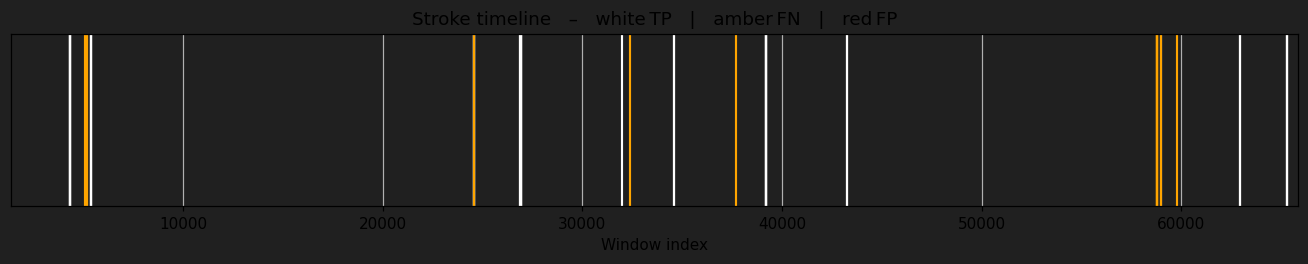

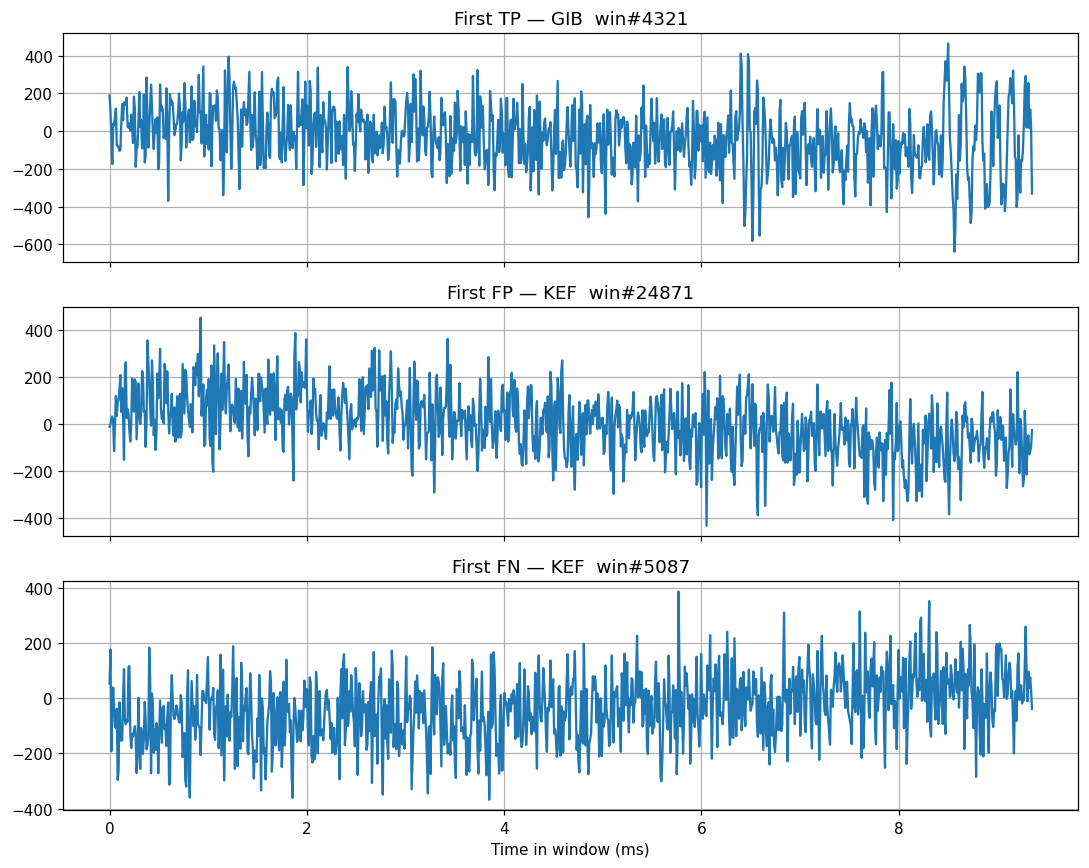


—— Station‑level window metrics ——
KEF: TP=0    FP=1     FN=245  P=0.000 R=0.000 F1=0.000
VAL: TP=9    FP=0     FN=236  P=1.000 R=0.037 F1=0.071
LER: TP=2    FP=0     FN=242  P=1.000 R=0.008 F1=0.016
HER: TP=4    FP=0     FN=240  P=1.000 R=0.016 F1=0.032
GIB: TP=38   FP=0     FN=209  P=1.000 R=0.154 F1=0.267
AKR: TP=2    FP=0     FN=243  P=1.000 R=0.008 F1=0.016
CAM: TP=19   FP=0     FN=224  P=1.000 R=0.078 F1=0.145
WAT: TP=9    FP=0     FN=237  P=1.000 R=0.037 F1=0.071
CAB: TP=2    FP=1     FN=245  P=0.667 R=0.008 F1=0.016
PAY: TP=10   FP=0     FN=234  P=1.000 R=0.041 F1=0.079
TAR: TP=0    FP=0     FN=247  P=0.000 R=0.000 F1=0.000

—— Network‑level stroke metrics ——
{'TP': 36, 'FP': 0, 'FN': 13, 'TN': 0, 'P': 1.0, 'R': 0.7346938775510204, 'F1': 0.8470588235294119}


In [11]:
##############################################################################
#  Model‑7  ·  Residual GAT Auto‑Encoder  (with FP–suppression)
#  --------------------------------------------------------------------------
#  • Station names are normalised to upper‑case once ➜ no KeyErrors.
#  • FP cut‑down:  3‑pt temporal majority  +  1‑station consensus (optional).
#  • End‑to‑end strict scoring via evaluate_windowed_model (unchanged API).
##############################################################################

import math, os, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from scipy.signal import hilbert, convolve
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GATv2Conv
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tqdm.auto import tqdm

torch.manual_seed(42); random.seed(42); np.random.seed(42)

# ───────────────── configuration ───────────────────────────────────────────
WIN, HOP   = 1024, 512
STN        = [s.upper() for s in station_order]          # ← force UPPER‑case
FS         = float(FS)
LAT_NODE   = 64
EPOCHS     = 10
BATCH      = 512
LR         = 2e-3
ROBUST_K   = 4.0                                         # median+K·MAD
MIN_STN    = 2
DEVICE     = 'cuda' if torch.cuda.is_available() else 'cpu'
BURST_LEN  = int(0.04*FS)

# ───────────────── tensors & features ──────────────────────────────────────
n_win   = (len(quantized[STN[0]]) - WIN)//HOP + 1
N_nodes = len(STN)

Raw  = np.empty((n_win, N_nodes, WIN), np.float32)
envp = np.empty(n_win)

for i, nm in enumerate(STN):
    s16  = quantized[nm]
    sig  = s16.astype(np.float32) / 32768.0
    env  = np.abs(hilbert(sig))
    for w in range(n_win):
        seg             = sig[w*HOP : w*HOP+WIN]
        Raw[w, i]       = seg
        if i == 0:
            envp[w]     = env[w*HOP : w*HOP+WIN].max()

def feats10(win):
    env = np.abs(hilbert(win))
    pk, md = env.max(), np.median(env)
    rms = np.sqrt((win**2).mean() + 1e-9)
    stalta = env[:256].mean()/(env.mean()+1e-9)
    P = np.abs(np.fft.rfft(win))**2; P /= P.sum()+1e-9
    q = [P[int(i*len(P)/4):int((i+1)*len(P)/4)].sum() for i in range(4)]
    return np.array([pk, md, pk/(md+1e-9), rms, pk/(rms+1e-9), stalta, *q],
                    np.float32)

lats = np.array([stations[n]['lat'] for n in STN])
lons = np.array([stations[n]['lon'] for n in STN])
lat0, lon0 = lats.mean(), lons.mean()
lat_rng, lon_rng = np.ptp(lats-lat0)+1e-6, np.ptp(lons-lon0)+1e-6
coords = [((la-lat0)/lat_rng, (lo-lon0)/lon_rng) for la,lo in zip(lats,lons)]

NODE_DIM = 12
Xnode = np.empty((n_win, N_nodes, NODE_DIM), np.float32)
for w in range(n_win):
    for i in range(N_nodes):
        Xnode[w,i,:10] = feats10(Raw[w,i])
        Xnode[w,i,10:] = coords[i]

# ───────────────── graph edges & attr ──────────────────────────────────────
edge_src, edge_dst = zip(*[(i,j) for i in range(N_nodes) for j in range(N_nodes)
                           if i != j])
edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long, device=DEVICE)

def hav_km(a1,o1,a2,o2):
    R=6371.0; φ1,φ2 = map(math.radians, (a1,a2))
    dφ, dλ = φ2-φ1, math.radians(o2-o1)
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

dist_km = np.array([[hav_km(stations[i]['lat'],stations[i]['lon'],
                            stations[j]['lat'],stations[j]['lon'])
                     for j in STN] for i in STN], np.float32)
d_n   = dist_km / dist_km.max()
inv_d = 1/(dist_km+1e-3)
delay = (dist_km/300_000.0*FS)/HOP
edge_attr = torch.tensor([[d_n[i,j], inv_d[i,j], delay[i,j]]
                          for i,j in zip(edge_src,edge_dst)],
                         dtype=torch.float32, device=DEVICE)

# ───────────────── dataset (prune obvious bursts) ──────────────────────────
mask_keep = envp < np.percentile(envp, 95)
train_idx = np.where(mask_keep)[0]

class WinDS(Dataset):
    def __len__(self): return len(train_idx)
    def __getitem__(self, k):
        idx = train_idx[k]
        return (torch.from_numpy(Xnode[idx]).to(DEVICE),
                torch.from_numpy(Raw[idx]).to(DEVICE))

dl = DataLoader(WinDS(), batch_size=BATCH, shuffle=True, drop_last=True)

# ───────────────── model ───────────────────────────────────────────────────
class GATBlock(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.conv = GATv2Conv(h,h,heads=8,concat=False,edge_dim=3)
        self.ln   = nn.LayerNorm(h)
    def forward(self,x,ei,ea):
        return self.ln(x + F.relu(self.conv(x,ei,ea)))

class GraphAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(NODE_DIM,96), nn.ReLU(),
                                 nn.Linear(96,LAT_NODE))
        self.gnn = nn.Sequential(GATBlock(LAT_NODE),
                                 GATBlock(LAT_NODE),
                                 GATBlock(LAT_NODE))
        self.dec = nn.Sequential(nn.Linear(LAT_NODE,256), nn.ReLU(),
                                 nn.Linear(256,WIN))
    def forward(self,x,ei,ea):
        z = self.enc(x)
        for blk in self.gnn: z = blk(z,ei,ea)
        return self.dec(z)

model = GraphAE().to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
loss_fn = nn.MSELoss()

# ───────────────── training ────────────────────────────────────────────────
print(f"▶ Training Graph‑AE on {DEVICE} …")
for ep in range(1,EPOCHS+1):
    s_loss, s_cnt = 0.0, 0
    for Xn,Wv in dl:
        B = Xn.size(0)
        x  = Xn.view(B*N_nodes, NODE_DIM)
        raw= Wv.view(B*N_nodes, WIN)
        rec= model(x, edge_index, edge_attr)
        loss = loss_fn(rec, raw)
        opt.zero_grad(); loss.backward(); opt.step()
        s_loss += loss.item()*B*N_nodes; s_cnt += B*N_nodes
    print(f"  ep{ep:02d}: mean‑MSE={s_loss/s_cnt:.4e}")

# ───────────────── window scoring ──────────────────────────────────────────
err = np.zeros((n_win,N_nodes), np.float32)
model.eval(); torch.set_grad_enabled(False)
for s in range(0,n_win,BATCH):
    e = min(n_win, s+BATCH); B = e-s
    Xb = torch.from_numpy(Xnode[s:e]).to(DEVICE)
    raw= torch.from_numpy(Raw[s:e]).to(DEVICE)
    rec = model(Xb.view(B*N_nodes,NODE_DIM), edge_index, edge_attr
               ).cpu().numpy().reshape(B,N_nodes,WIN)
    err[s:e] = ((rec - raw.cpu().numpy())**2).mean(axis=2)

# ───────────────── per‑station robust threshold ────────────────────────────
hot = {}
for i,nm in enumerate(STN):
    e   = err[:,i]
    med = np.median(e); mad = np.median(np.abs(e-med))+1e-9
    hot[nm] = (e - med) / mad > ROBUST_K
    print(f"{nm}: median={med:.2e}  MAD={mad:.2e}  → raw‑flagged={hot[nm].sum()}")

# ───────────────── FP‑suppression (once, AFTER masks exist) ────────────────
SMOOTH, CONSENSUS, N_AGREE = True, True, 1

if SMOOTH:
    ker = np.array([1,1,1], int)
    for nm in STN:
        m        = convolve(hot[nm].astype(int), ker, mode="same")
        hot[nm]  = m >= 2                               # majority

if CONSENSUS:
    stack = np.stack([hot[n] for n in STN])            # (S, n_win)
    neigh = np.pad(stack, ((0,0),(1,1)), 'constant')
    neigh = neigh[:, :-2] + stack + neigh[:, 2:]       # ±1 hop
    for i,nm in enumerate(STN):
        others = neigh.sum(axis=0) - neigh[i]
        hot[nm] &= others >= N_AGREE

print("▶ After suppression:")
for nm in STN:
    print(f"  {nm}: final‑flagged={hot[nm].sum()}")

# ───────────────── strict evaluation (unchanged) ───────────────────────────
station_metrics, network_metrics, _ = evaluate_windowed_model(
    hot           = hot,
    stroke_records= stroke_records,
    quantized     = quantized,
    station_order = STN,
    win           = WIN,
    hop           = HOP,
    burst_len     = BURST_LEN,
    min_stn       = MIN_STN,
    tol_win       = 0,
    plot          = True
)

print("\n—— Station‑level window metrics ——")
for nm,m in station_metrics.items():
    print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
          f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")

print("\n—— Network‑level stroke metrics ——")
print(network_metrics)


In [12]:
##############################################################################
#  Lightning‑detection “model 9” – NCD (4 encoder variants) + strict scoring
#  -------------------------------------------------------------------------
#  • Sections 1‑5 below reproduce your existing multi‑variant NCD pipeline
#    unchanged: feature encoding, NCD computation, and the quick inline
#    stroke tables produced by `report_variant`.
#  • Section 6 (new) loops over each encoder variant, builds the
#    `{station: hot‑mask}` mapping, and feeds it to the strict,
#    burst‑aware `evaluate_windowed_model` so you get rigorous station/window
#    and stroke/network metrics plus the timeline+waveform UI.
##############################################################################

# ── Imports ─────────────────────────────────────────────────
import numpy as np, bz2, tqdm.auto as tq
from functools      import lru_cache
from collections    import Counter, defaultdict
from scipy.stats    import describe
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score
)

# ── Global parameters (unchanged) ───────────────────────────
WIN, HOP   = 1024, 512
BASE_PCT   = 5
PCT_THR    = 98.5
Z_SIGMA    = 3.5
MIN_STN    = 2
STN        = station_order
FS         = float(FS)
BURST_LEN  = int(0.04*FS)     # 40 ms burst for strict evaluator

# ── Helper: haversine (needed for stroke → first‑arrival) ───
def hav(lat1, lon1, lat2, lon2):
    R = 6371.0
    φ1, φ2 = map(np.radians, (lat1, lat2))
    dφ = φ2 - φ1
    dλ = np.radians(lon2 - lon1)
    a = np.sin(dφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(dλ/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# ── Window view utility (stride‑trick) ──────────────────────
def win_view(sig: np.ndarray, W: int, H: int):
    n = (len(sig) - W)//H + 1
    return np.lib.stride_tricks.as_strided(
        sig,
        shape=(n, W),
        strides=(sig.strides[0]*H, sig.strides[0])
    )

# ── Compression size cache (bzip2, level 9) ─────────────────
@lru_cache(maxsize=None)
def c_size(b: bytes) -> int:
    return len(bz2.compress(b, 9))

# ── Encoders (4 variants) ───────────────────────────────────
def enc_bits(arr):
    diff = np.diff(arr.astype(np.int16), prepend=arr[0])
    return np.packbits((diff > 0).astype(np.uint8)).tobytes()
def enc_raw(arr):   return arr.astype(np.int16).tobytes()
def enc_norm(arr):
    a = arr.astype(np.float32)
    a = (a - a.mean()) / (a.std(ddof=0) + 1e-9)
    a = np.clip(a*32767, -32767, 32767).astype(np.int16)
    return a.tobytes()
def enc_tanh(arr):
    a = np.tanh(arr.astype(np.float32) / 16384.0) * 32767
    return a.astype(np.int16).tobytes()

ENCODERS = dict(bits=enc_bits, raw=enc_raw, norm=enc_norm, tanh=enc_tanh)

# ── Pre‑compute common window count ─────────────────────────
n_win = min(((len(quantized[n]) - WIN)//HOP) + 1 for n in STN)
print(f"\nAnalysing {n_win:,} windows  ×  {len(STN)} stations  ×  {len(ENCODERS)} encodings\n")

# ── Main loop: build NCD vectors for every variant & station ─
ncd_meta = defaultdict(dict)   # two‑level dict

for enc_name, enc_fun in ENCODERS.items():
    print(f"\n=== Variant: {enc_name} ===")
    for nm in STN:
        sig  = quantized[nm]
        wmat = win_view(sig, WIN, HOP)

        # pass 1 – pre‑compute compressed size of each window
        comp_sz = np.empty(n_win, np.uint32)
        for i in tq.trange(n_win, desc=f"{nm} size", leave=False):
            comp_sz[i] = c_size(enc_fun(wmat[i]))

        # choose baseline window = median of lowest BASE_PCT %
        k          = max(1, int(BASE_PCT/100 * n_win))
        low_idx    = np.argpartition(comp_sz, k)[:k]
        base_idx   = low_idx[np.argsort(comp_sz[low_idx])[k//2]]
        base_bytes = enc_fun(wmat[base_idx])
        Cb         = c_size(base_bytes)

        # pass 2 – NCD to baseline for every window
        ncd_vec = np.empty(n_win, float)
        for i in tq.trange(n_win, desc=f"{nm} NCD", leave=False):
            wb = enc_fun(wmat[i])
            ncd_vec[i] = (c_size(wb + base_bytes) - min(comp_sz[i], Cb)) / max(comp_sz[i], Cb)

        # derive adaptive threshold
        stats   = describe(ncd_vec)
        thr_pct = np.percentile(ncd_vec, PCT_THR)
        thr_z   = stats.mean + Z_SIGMA*np.sqrt(stats.variance)
        thr     = min(thr_pct, thr_z)
        hot     = ncd_vec > thr

        ncd_meta[enc_name][nm] = dict(ncd=ncd_vec, hot=hot, thr=thr, desc=stats)
        print(f" {nm}: hot={hot.sum():5d}  thr={thr:.4f}")

# ── Build canonical stroke index list (earliest arrival) ───
stroke_idx = np.array([
    min(int((t0 + hav(ev['lat'], ev['lon'],
                      stations[n]['lat'], stations[n]['lon']) / 300_000) * FS)
        for n in STN)
    for ev in events for t0 in ev['stroke_times']
])
truth = np.ones(len(stroke_idx), bool)

# ── Variant‑specific stroke coincidence matrices (INLINE) ──
variant_hits = {}
for enc_name in ENCODERS:
    hits = np.zeros((len(STN), len(stroke_idx)), bool)
    for s, nm in enumerate(STN):
        hot = ncd_meta[enc_name][nm]['hot']
        for j, i0 in enumerate(stroke_idx):
            w = i0 // HOP
            hits[s, j] = hot[max(0, w-1):min(len(hot), w+2)].any()   # ⚠ ±1 slack, FP invisible
    variant_hits[enc_name] = hits

def report_variant(name, hits):
    cnt = hits.sum(axis=0)
    print(f"\n### {name} encoding  (INLINE diagnostic) ###")
    print("Stations ≥thr per stroke:")
    for k, v in sorted(Counter(cnt).items()):
        print(f"  {k:2d} → {v}")
    net_pred = cnt >= MIN_STN
    tn, fp, fn, tp = confusion_matrix(truth, net_pred, labels=[False, True]).ravel()
    P = precision_score(truth, net_pred, zero_division=0)
    R = recall_score   (truth, net_pred, zero_division=0)
    F = f1_score       (truth, net_pred, zero_division=0)
    print(f"Network: TP={tp} FP={fp} FN={fn} TN={tn} | P={P:.3f} R={R:.3f} F1={F:.3f}")
    print("stn  TP  FP  FN    P     R    F1")
    for s, nm in enumerate(STN):
        pred = hits[s]
        tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[False, True]).ravel()
        P = precision_score(truth, pred, zero_division=0)
        R = recall_score   (truth, pred, zero_division=0)
        F = f1_score       (truth, pred, zero_division=0)
        print(f"{nm:>3} {tp:3d} {fp:3d} {fn:3d}  {P:5.3f} {R:5.3f} {F:5.3f}")

for enc in ENCODERS:
    report_variant(enc, variant_hits[enc])

# ────────────────────────────────────────────────────────────────────────────
#  6) Strict, burst‑aware evaluation for each encoder variant
# ────────────────────────────────────────────────────────────────────────────
for enc in ENCODERS:
    print(f"\n================  STRICT EVALUATION: {enc}  ================")
    hot_masks = {nm: ncd_meta[enc][nm]['hot'] for nm in STN}
    station_metrics, network_metrics, n_windows = evaluate_windowed_model(
        hot          = hot_masks,
        stroke_records = stroke_records,
        quantized      = quantized,
        station_order  = STN,
        win            = WIN,
        hop            = HOP,
        burst_len      = BURST_LEN,
        min_stn        = MIN_STN,
        tol_win        = 0,
        plot           = True
    )
    print(f"\n—— Station / window metrics  (n_windows = {n_windows:,}) ——")
    for nm, m in station_metrics.items():
        print(f"{nm}: TP={m['TP']:<4} FP={m['FP']:<5} FN={m['FN']:<4} "
              f"P={m['P']:.3f} R={m['R']:.3f} F1={m['F1']:.3f}")
    print("\n—— Network / stroke metrics ——")
    print(network_metrics)



Analysing 67,688 windows  ×  11 stations  ×  4 encodings


=== Variant: bits ===


 KEF: hot=  990  thr=0.8374


 VAL: hot= 1013  thr=0.8350


 LER: hot= 1002  thr=0.8267


 HER: hot= 1012  thr=0.7902


 GIB: hot= 1006  thr=0.8000


 AKR: hot= 1016  thr=0.8095


 CAM: hot=  994  thr=0.8341


 WAT: hot= 1000  thr=0.8186


 CAB: hot=  993  thr=0.8276


 PAY: hot=  986  thr=0.8293


 TAR: hot=  988  thr=0.8276

=== Variant: raw ===


 KEF: hot= 1016  thr=0.8527


 VAL: hot= 1013  thr=0.8526


 LER: hot= 1013  thr=0.8554


 HER: hot= 1016  thr=0.8575


 GIB: hot= 1016  thr=0.8605


 AKR: hot= 1015  thr=0.8487


 CAM: hot= 1014  thr=0.8447


 WAT: hot= 1011  thr=0.8533


 CAB: hot= 1014  thr=0.8452


 PAY: hot= 1014  thr=0.8545


 TAR: hot= 1001  thr=0.8511

=== Variant: norm ===


 KEF: hot= 1016  thr=1.0006


 VAL: hot= 1016  thr=1.0112


KeyboardInterrupt: 